In [36]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt 

from torch_geometric.data import Data
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear
#from torchmetrics.functional.regression import r2_score
from sklearn.metrics import r2_score

In [23]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [24]:
# load in data (GNPC supplementary table 5)
file_path = 'gnpc_supp.xlsx'
sheet_name = 'SuppTbl5'
df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)

In [3]:
df.columns

Index(['SeqId', 'SomaId', 'TargetFullName', 'Target', 'UniProt',
       'EntrezGeneID', 'EntrezGeneSymbol', 'Organism',
       'Avg_StdBeta_weighted_AD', 'Meta_p_weighted_AD', 'Meta_pval_FDR_AD',
       'Meta_pval_Bonf_AD', 'Sig_pos_AD', 'Sig_neg_AD', 'max_sites_AD',
       'AD_StdBeta_A', 'AD_p_A', 'AD_StdBeta_C', 'AD_p_C', 'AD_StdBeta_D',
       'AD_p_D', 'AD_StdBeta_E', 'AD_p_E', 'AD_StdBeta_F', 'AD_p_F',
       'AD_StdBeta_I', 'AD_p_I', 'AD_StdBeta_J', 'AD_p_J', 'AD_StdBeta_L',
       'AD_p_L', 'AD_StdBeta_G', 'AD_p_G', 'AD_StdBeta_R', 'AD_p_R',
       'Avg_StdBeta_weighted_PD', 'Meta_p_weighted_PD', 'Meta_pval_FDR_PD',
       'Meta_pval_Bonf_PD', 'Sig_pos_PD', 'Sig_neg_PD', 'max_sites_PD',
       'PD_StdBeta_C', 'PD_p_C', 'PD_StdBeta_F', 'PD_p_F', 'PD_StdBeta_J',
       'PD_p_J', 'PD_StdBeta_L', 'PD_p_L', 'PD_StdBeta_Q', 'PD_p_Q',
       'PD_StdBeta_R', 'PD_p_R', 'PD_StdBeta_T', 'PD_p_T',
       'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD', 'Meta_pval_FDR_FTD',
       'Meta_p

In [25]:
# select only the columns we need for training/prediction
col_for_training = ['EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD', 'Meta_p_weighted_AD', 'Avg_StdBeta_weighted_PD', 'Meta_p_weighted_PD',
                    'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD', 'StdBeta_ALS', 'p_ALS'] 

features_df = df[col_for_training].copy() # avoids SettingWithCopyWarning warning in next cell
features_df.rename(columns={'EntrezGeneSymbol' : 'EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD' : 'AD_beta', 
                            'Meta_p_weighted_AD' : 'AD_p', 'Avg_StdBeta_weighted_PD' : 'PD_beta', 'Meta_p_weighted_PD' : 'PD_p',
                            'Avg_StdBeta_weighted_FTD' : 'FTD_beta', 'Meta_p_weighted_FTD' : 'FTD_p', 'StdBeta_ALS': 'ALS_beta', 'p_ALS' : 'ALS_p'
                            }, inplace=True)# rename cols for easier access  
features_df.head()

,EntrezGeneSymbol,AD_beta,AD_p,PD_beta,PD_p,FTD_beta,FTD_p,ALS_beta,ALS_p
0,CRYBB2,0.020411,0.105892,-0.019541,0.002026,0.016847,0.126806,-0.075116,0.201204
1,RAF1,-0.018095,0.863149,0.004977,0.189185,0.007533,0.393355,-0.052058,0.369734
2,ZNF41,0.049706,0.000772,0.004067,0.466674,0.000385,0.385409,0.015578,0.790375
3,ELK1,0.028990,0.002776,0.010033,0.580357,0.000471,0.457739,0.088028,0.129374
4,GUCA1A,-0.014837,0.151340,-0.006160,0.018256,-0.054077,0.095542,0.030428,0.603799


In [26]:
# data cleaning
# remove NAs & fill with zero, keep only the first duplicate for genes with multiple entries

print(f"Shape before: {features_df.shape}")
features_df.drop_duplicates(subset='EntrezGeneSymbol', keep='first', inplace=True)
features_df.set_index('EntrezGeneSymbol', inplace=True)
features_df.fillna(0, inplace=True)
print(f"Shape after: {features_df.shape}")

Shape before: (7292, 9)
Shape after: (6386, 8)


In [27]:
# feature engineering
# p values could really skew our overall data distribution, so we will -log transform them

# small value added to prevent log(0)
epsilon = 1e-8

# create the -log10(p-value) features
p_value_cols = ['AD_p', 'PD_p', 'FTD_p', 'ALS_p']
for col in p_value_cols:
    new_col_name = col.replace('_p', '_logp')
    features_df[new_col_name] = -np.log10(features_df[col] + epsilon)

# create feature matrix
final_features = [
    'AD_beta', 'AD_logp',
    'PD_beta', 'PD_logp',
    'FTD_beta', 'FTD_logp',
    'ALS_beta', 'ALS_logp'
]

# filter out old p value cols
final_features_df = features_df[final_features]
final_features_df.head()

,AD_beta,AD_logp,PD_beta,PD_logp,FTD_beta,FTD_logp,ALS_beta,ALS_logp
EntrezGeneSymbol,,,,,,,,
CRYBB2,0.020411,0.975136,-0.019541,2.693365,0.016847,0.896860,-0.075116,0.696364
RAF1,-0.018095,0.063914,0.004977,0.723114,0.007533,0.405216,-0.052058,0.432111
ZNF41,0.049706,3.112230,0.004067,0.330987,0.000385,0.414078,0.015578,0.102167
ELK1,0.028990,2.556574,0.010033,0.236305,0.000471,0.339382,0.088028,0.888151
GUCA1A,-0.014837,0.820047,-0.006160,1.738601,-0.054077,1.019804,0.030428,0.219107


In [28]:
# Create UniProt to Gene Symbol Mapping (from Yasemin's code)

file_name = 'gnpc_supp.xlsx'
sheet_name = 'SuppTbl5'

# Load the Original GNPC Data to get the mapping 
original_df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)
print("Original GNPC table shape:", original_df.shape)

# Select only the columns we need for mapping and drop missing values
mapping_df = original_df[['UniProt', 'EntrezGeneSymbol']].dropna().copy()

# If a gene has multiple symbols separated by ';', keep the first one
mapping_df['EntrezGeneSymbol'] = (
    mapping_df['EntrezGeneSymbol']
    .astype(str)
    .apply(lambda x: x.split(';')[0])
)

# Ensure each UniProt appears only once
mapping_df = mapping_df.drop_duplicates(subset='UniProt')

# Create the dictionary: {UniProt_ID: GeneSymbol}
uniprot_to_gene_map = dict(zip(mapping_df['UniProt'], mapping_df['EntrezGeneSymbol']))

print(f"Created a mapping dictionary with {len(uniprot_to_gene_map)} entries.")
print("Example mappings:", list(uniprot_to_gene_map.items())[:5])

Original GNPC table shape: (7292, 77)
Created a mapping dictionary with 6387 entries.
Example mappings: [('P43320', 'CRYBB2'), ('P04049', 'RAF1'), ('P51814', 'ZNF41'), ('P19419', 'ELK1'), ('P43080', 'GUCA1A')]


In [29]:
# load in nodes and edges
nodes_raw = pd.read_csv('ppi_nodes_raw.csv')
edges_raw = pd.read_csv('ppi_edges_raw.csv')

print(nodes_raw.shape)
print(edges_raw.shape)

(5505, 3)
(80102, 4)


In [30]:
# Map STRING indices -> UniProt
idx_to_uniprot = nodes_raw.set_index('index')['UniProt'].to_dict()

edges_raw['protein1_uniprot'] = edges_raw['src'].map(idx_to_uniprot)
edges_raw['protein2_uniprot'] = edges_raw['dst'].map(idx_to_uniprot)

print("\nAfter mapping indices to UniProt:")
print(edges_raw[['src', 'dst', 'protein1_uniprot', 'protein2_uniprot']].head())

# Map UniProt -> GeneSymbol 

edges_raw['protein1'] = edges_raw['protein1_uniprot'].map(uniprot_to_gene_map)
edges_raw['protein2'] = edges_raw['protein2_uniprot'].map(uniprot_to_gene_map)

# Drop rows where translation failed
translated_edges_df = edges_raw.dropna(subset=['protein1', 'protein2']).copy()
print(f"\nAfter UniProt→GeneSymbol mapping: {len(translated_edges_df)} edges remain")


# Set of proteins that actually have GNPC features
valid_gene_symbols = set(features_df.index)

print(f"{len(valid_gene_symbols)} unique gene symbols to use as our node list")

# Now filter edges
filtered_edges_df = translated_edges_df[
    translated_edges_df['protein1'].isin(valid_gene_symbols) &
    translated_edges_df['protein2'].isin(valid_gene_symbols)
].copy()

print(f"Kept {len(filtered_edges_df)} out of {len(translated_edges_df)} edges.")

# Filtering by min confidence score:

min_weight = 0.7
pre_conf_count = len(filtered_edges_df)
filtered_edges_df = filtered_edges_df[filtered_edges_df['weight'] >= min_weight].copy()
print(f"Applied weight >= {min_weight}: kept {len(filtered_edges_df)} / {pre_conf_count} edges.")

# Remove self-loops
pre_self_loop_count = len(filtered_edges_df)
filtered_edges_df = filtered_edges_df[filtered_edges_df['protein1'] != filtered_edges_df['protein2']]
print(f"Removed {pre_self_loop_count - len(filtered_edges_df)} self-loops.")

# Deduplicate undirected edges, keeping the highest-weight interaction per pair
filtered_edges_df['pair'] = filtered_edges_df.apply(
    lambda r: tuple(sorted((r['protein1'], r['protein2']))),
    axis=1
)

filtered_edges_df = filtered_edges_df.sort_values('weight', ascending=False)
dedup_edges_df = filtered_edges_df.drop_duplicates(subset='pair', keep='first')

dedup_edges_df['protein1_clean'] = dedup_edges_df['pair'].apply(lambda p: p[0])
dedup_edges_df['protein2_clean'] = dedup_edges_df['pair'].apply(lambda p: p[1])

edges_final = dedup_edges_df[['protein1_clean', 'protein2_clean', 'weight']].rename(
    columns={'protein1_clean': 'protein1', 'protein2_clean': 'protein2'}
)

print(f"Removed duplicates; final edge count: {len(edges_final)}")


After mapping indices to UniProt:
   src   dst protein1_uniprot protein2_uniprot
0    0   904           P84085           O75154
1    0  1878           P84085           P18085
2    0  4898           P84085           P84077
3    0  1629           P84085           P53367
4    0  5307           P84085           P53365

After UniProt→GeneSymbol mapping: 79834 edges remain
6386 unique gene symbols to use as our node list
Kept 79834 out of 79834 edges.
Applied weight >= 0.7: kept 79834 / 79834 edges.
Removed 130 self-loops.
Removed duplicates; final edge count: 39381


/tmp/ipykernel_29710/1213277067.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dedup_edges_df['protein1_clean'] = dedup_edges_df['pair'].apply(lambda p: p[0])
/tmp/ipykernel_29710/1213277067.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dedup_edges_df['protein2_clean'] = dedup_edges_df['pair'].apply(lambda p: p[1])


In [31]:
# from Yasemin's code
# 3. Create mapping from gene symbol to node index
gene_symbols = features_df.index.tolist()
gene_to_idx = {gene: i for i, gene in enumerate(gene_symbols)}
print(f"Created mapping for {len(gene_to_idx)} genes to integer indices.")

# Ensure all edges refer to known genes 
edges_df = edges_final[
    edges_final['protein1'].isin(gene_to_idx) &
    edges_final['protein2'].isin(gene_to_idx)
].copy()
print(f"Edges after checking the presence in gene_to_idx: {len(edges_df)}")

# 4. Build edge_index and edge_attr (confidence weights)
edge_index = torch.tensor([
    [gene_to_idx[p] for p in edges_df['protein1']],
    [gene_to_idx[p] for p in edges_df['protein2']],
], dtype=torch.long)

edge_weight = torch.tensor(edges_df['weight'].values, dtype=torch.float32)

Created mapping for 6386 genes to integer indices.
Edges after checking the presence in gene_to_idx: 39381


In [32]:
# Generate torch_geometric.data.data Data object

#scaler = StandardScaler() # we need to scale our beta values and p values

label_cols   = ['AD_beta', 'PD_beta', 'FTD_beta', 'ALS_beta']
feature_cols = ['AD_logp', 'PD_logp', 'FTD_logp', 'ALS_logp']

# create X
#X_scaled = scaler.fit_transform(final_features_df[feature_cols].values)
X = torch.tensor(final_features_df[feature_cols].values, dtype=torch.float)

# create Y - we're predicting beta values for all 4 diseases
#y_df = final_features_df[label_cols] 
#y_scaled = scaler.fit_transform(y_df.values)
Y = torch.tensor(final_features_df[label_cols].values, dtype=torch.float)


# create training, validation, and testing masks (60/20/20 split)
N = final_features_df.shape[0]
split_labels = np.random.choice([0, 1, 2], N, p = [0.6, 0.2, 0.2]) # 0 is train, 1 is val, 2 is test

train_mask = torch.tensor(split_labels==0, dtype=torch.bool)
val_mask = torch.tensor(split_labels==1, dtype=torch.bool)
test_mask = torch.tensor(split_labels==2, dtype=torch.bool)

# create data object
graph_data = Data(
    x=X,
    edge_index=edge_index,
    edge_weights=edge_weight,
    y=Y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask, 
    gene_symbols=gene_symbols
)
graph_data

import os
# 7. Save to the path used by your training script
output_file = '/home/devle/chem_277B/Chem277-Team4-Project/GCN_all4/processed_graph.pt'
os.makedirs(os.path.dirname(output_file), exist_ok=True)
torch.save(graph_data, output_file)

print(f"\nSaved graph data to '{output_file}'")


Saved graph data to '/home/devle/chem_277B/Chem277-Team4-Project/GCN_all4/processed_graph.pt'


In [33]:
def get_loss_weights(df):
    '''
    Calculates weights for loss function terms based on inverse variance of beta values.

    Parameters
    ----------
    df : Pandas DataFrame that includes the columns "AD_beta", "PD_beta", "FTD_beta", "ALS_beta"

    Returns
    -------
    ad_wt, pd_wt, ftd_wt, als_wt : weights for each component of the combined loss function
    '''

    betas = df[["AD_beta", "PD_beta", "FTD_beta", "ALS_beta"]]

    # get variance of beta values for each disease 
    variances_by_disease = betas.var()

    # calculate inverse variance to use as weight
    inverse_variances = 1/variances_by_disease.values

    # normalize weights so they add up to 1
    normalized_wts = inverse_variances / inverse_variances.sum()

    ad_wt, pd_wt, ftd_wt, als_wt = normalized_wts

    return ad_wt, pd_wt, ftd_wt, als_wt

AD_wt = get_loss_weights(final_features_df)[0]
PD_wt = get_loss_weights(final_features_df)[1]
FTD_wt = get_loss_weights(final_features_df)[2]
ALS_wt = get_loss_weights(final_features_df)[3]

Epoch 000 | Train: 1.0135 | Val: 0.9604 * NEW BEST
Epoch 001 | Train: 1.0068 | Val: 0.9549 * NEW BEST
Epoch 002 | Train: 1.0050 | Val: 0.9481 * NEW BEST
Epoch 003 | Train: 1.0035 | Val: 0.9482
Epoch 004 | Train: 0.9990 | Val: 0.9493
Epoch 005 | Train: 0.9970 | Val: 0.9455 * NEW BEST
Epoch 006 | Train: 0.9930 | Val: 0.9489
Epoch 007 | Train: 0.9906 | Val: 0.9444 * NEW BEST
Epoch 008 | Train: 0.9894 | Val: 0.9401 * NEW BEST
Epoch 009 | Train: 0.9859 | Val: 0.9429
Epoch 010 | Train: 0.9835 | Val: 0.9375 * NEW BEST
Epoch 011 | Train: 0.9825 | Val: 0.9370 * NEW BEST
Epoch 012 | Train: 0.9814 | Val: 0.9376
Epoch 013 | Train: 0.9794 | Val: 0.9313 * NEW BEST
Epoch 014 | Train: 0.9797 | Val: 0.9349
Epoch 015 | Train: 0.9735 | Val: 0.9322
Epoch 016 | Train: 0.9732 | Val: 0.9336
Epoch 017 | Train: 0.9726 | Val: 0.9308 * NEW BEST
Epoch 018 | Train: 0.9670 | Val: 0.9291 * NEW BEST
Epoch 019 | Train: 0.9725 | Val: 0.9202 * NEW BEST
Epoch 020 | Train: 0.9660 | Val: 0.9267
Epoch 021 | Train: 0.9693 | 

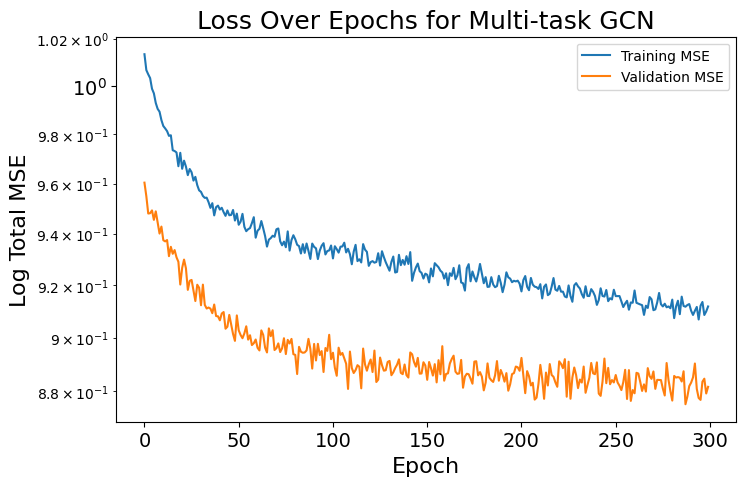

In [37]:
# model - 2 layer GCN  with 4 outputs (regression for beta prediction for each disease)
class My_GCN(torch.nn.Module):
    
    def __init__(self, num_features, n_neurons, dropout):
        '''
        Initializes an instances of the My_GCN class.

        Parameters
        ----------
        num_features : int
            Number of features in the feature tensor (X).
        n_neurons : int
            Number of dimensions in the space that input features are transformed to.
        dropout : float
            Percentage that determines how many neurons are ignored during a foward/backward pass.

        '''
        super(My_GCN, self).__init__()
        
        self.dropout = dropout

        self.conv1 = GCNConv(num_features, n_neurons)
        self.conv2 = GCNConv(n_neurons, n_neurons)

        # linear layers for beta prediction for each disease
        self.out_ad = Linear(n_neurons, 1) 
        self.out_pd = Linear(n_neurons, 1) 
        self.out_ftd = Linear(n_neurons, 1)  
        self.out_als = Linear(n_neurons, 1) 

    def forward(self, data):
        '''
        Forward pass for the 2-layer GCN. 

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        Returns
        -------
        AD_pred, PD_pred, FTD_pred, ALS_pred : Pytorch tensors
            Beta value predictions for each disease.
        '''        
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weights

        x1 = self.conv1(x, edge_index, edge_weight)
        x2 = F.relu(x1)
        x3 = F.dropout(x2, p=self.dropout, training=self.training)

        x4 = self.conv2(x3, edge_index, edge_weight)
        x5 = F.relu(x4)

        # get predictions for each disease, removing dimension of 1
        AD_pred = self.out_ad(x5).squeeze(1)
        PD_pred = self.out_pd(x5).squeeze(1)
        FTD_pred = self.out_ftd(x5).squeeze(1)
        ALS_pred = self.out_als(x5).squeeze(1)
        
        return AD_pred, PD_pred, FTD_pred, ALS_pred

class FitModel():
    
    def __init__(self, my_model, learning_rate: float = 0.01):
        
        # Adam for optimization
        self.optimizer = torch.optim.Adam(my_model.parameters(), lr = learning_rate)
        self.model = my_model

    def get_metrics(self, data, mask, y_mean, y_std):
        ''' 
        Calculates MSE and R^2 for each disease beta prediction in the original space.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        mask : NumPy array
            Proteins (nodes) used for either training, validation, or testing.

        Returns
        -------
        MSE_ad, MSE_pd, MSE_ftd, MSE_als : float
            MSE and R^2 values for each disease beta prediction.
        '''

        out1, out2, out3, out4 = self.model(data) # get predictions

        # inverse transform scalers for better MSE interpretation
        y_mean_t = torch.tensor(y_mean, device=data.y.device)
        y_std_t = torch.tensor(y_std, device=data.y.device)

        # inverse transform predictions for each disease 
        AD_pred_orig = (out1 * y_std_t[0]) + y_mean_t[0]
        AD_target_orig = (data.y[:, 0] * y_std_t[0]) + y_mean_t[0]

        PD_pred_orig = (out2 * y_std_t[1]) + y_mean_t[1]
        PD_target_orig = (data.y[:, 1] * y_std_t[1]) + y_mean_t[1]

        FTD_pred_orig = (out3 * y_std_t[2]) + y_mean_t[2]
        FTD_target_orig = (data.y[:, 2] * y_std_t[2]) + y_mean_t[2]

        ALS_pred_orig = (out4 * y_std_t[3]) + y_mean_t[3]
        ALS_target_orig = (data.y[:, 3] * y_std_t[3]) + y_mean_t[3]

        # calculate MSE
        MSE_ad = F.mse_loss(AD_pred_orig[mask], AD_target_orig[mask])
        MSE_pd = F.mse_loss(PD_pred_orig[mask], PD_target_orig[mask])
        MSE_ftd = F.mse_loss(FTD_pred_orig[mask], FTD_target_orig[mask])
        MSE_als = F.mse_loss(ALS_pred_orig[mask], ALS_target_orig[mask])

        # convert to np for R2 calculation
        AD_target_np = AD_target_orig[mask].detach().cpu().numpy()
        AD_pred_np = AD_pred_orig[mask].detach().cpu().numpy()

        PD_target_np = PD_target_orig[mask].detach().cpu().numpy()
        PD_pred_np = PD_pred_orig[mask].detach().cpu().numpy()

        FTD_target_np = FTD_target_orig[mask].detach().cpu().numpy()
        FTD_pred_np = FTD_pred_orig[mask].detach().cpu().numpy()
        ALS_target_np = ALS_target_orig[mask].detach().cpu().numpy()
        ALS_pred_np = ALS_pred_orig[mask].detach().cpu().numpy()

        # calculate R^2
        R2_ad = r2_score(AD_target_np, AD_pred_np)
        R2_pd = r2_score(PD_target_np, PD_pred_np)
        R2_ftd = r2_score(FTD_target_np, FTD_pred_np)
        R2_als = r2_score(ALS_target_np, ALS_pred_np)

        # create dictionary to return
        metrics = {
            'MSE_ad' : MSE_ad, 
            'R2_ad' : R2_ad,
            'MSE_pd' : MSE_pd, 
            'R2_pd' : R2_pd,
            'MSE_ftd' : MSE_ftd,
            'R2_ftd' : R2_ftd,
            'MSE_als' : MSE_als,
            'R2_als' : R2_als
        }

        return metrics
    
    def get_scaled_MSE(self, data, mask):
        '''Get scaled MSE values for model training'''

        out1, out2, out3, out4 = self.model(data)

        # calculate MSE for each disease beta prediction
        MSE_ad = F.mse_loss(out1[mask], data.y[mask, 0])
        MSE_pd = F.mse_loss(out2[mask], data.y[mask, 1])
        MSE_ftd = F.mse_loss(out3[mask], data.y[mask, 2])
        MSE_als = F.mse_loss(out4[mask], data.y[mask, 3])

        return MSE_ad, MSE_pd, MSE_ftd, MSE_als
        
    def run(self, data, y_mean, y_std, N_epochs: int = 300):
        '''
        Runs the training loop, validation, and testing on the best model identified by validation loss.

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        N_epochs : int
            Number of times to run the training loop. 

        Returns
        -------
        total_loss : float
            Total loss for the final epoch.
        best_val_loss : float
            Best validation loss found over N_epochs.
        '''
        best_val_loss = float('inf')

        # intialize lists so we can plot MSE over epochs
        train_losses = []
        val_losses = []
        epoch_nums = []

        # initialize dictionaries to store metrics for best model
        best_train_metrics = {}
        best_val_metrics = {}
        
        for n in range(N_epochs):
            
            self.model.train() # set model to training mode (learning is occurring)
            self.optimizer.zero_grad()

            # get train MSE for each disease
            ad_loss, pd_loss, ftd_loss, als_loss = self.get_scaled_MSE(data, data.train_mask)
            total_loss = AD_wt*ad_loss + PD_wt*pd_loss + FTD_wt*ftd_loss + ALS_wt*als_loss
            total_loss.backward()
            self.optimizer.step()

            # get metrics (training) in original space
            train_metrics = self.get_metrics(data, data.train_mask, y_mean, y_std)
    
            # get metrics (validation) in original space
            with torch.no_grad():
                val_metrics = self.get_metrics(data, data.val_mask, y_mean, y_std)
                
                # get val MSE for each disease (scaled space)
                ad_val_loss, pd_val_loss, ftd_val_loss, als_val_loss = self.get_scaled_MSE(data, data.val_mask)
                total_val_loss = AD_wt*ad_val_loss + PD_wt*pd_val_loss + FTD_wt*ftd_val_loss + ALS_wt*als_val_loss

            # add losses & current epoch to lists
            train_losses.append(total_loss.item())
            val_losses.append(total_val_loss.item())
            epoch_nums.append(n)
            
            # compare current loss to best loss
            if total_val_loss.item() < best_val_loss:
                best_val_loss = total_val_loss
                best_train_metrics = train_metrics
                best_val_metrics = val_metrics

                # save best model
                torch.save(self.model.state_dict(), 'best_model.pt')

                print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f} * NEW BEST")
            else:
                print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f}")

        # testing loss
        # get best model
        self.model.load_state_dict(torch.load('best_model.pt'))

        # get metrics (test)
        with torch.no_grad():
            self.model.eval()
            
            best_train_metrics = self.get_metrics(data, data.train_mask, y_mean, y_std)
            best_val_metrics = self.get_metrics(data, data.val_mask, y_mean, y_std)
            test_metrics = self.get_metrics(data, data.test_mask, y_mean, y_std)
            
            # Calculate final test loss (scaled for comparison to val/train losses)
            ad_test_loss, pd_test_loss, ftd_test_loss, als_test_loss = self.get_scaled_MSE(data, data.test_mask)
            total_test_loss = AD_wt*ad_test_loss + PD_wt*pd_test_loss + FTD_wt*ftd_test_loss + ALS_wt*als_test_loss


        print(f"Best val loss: {best_val_loss.item()}")   
        print(f"Test loss for best model: {total_test_loss.item()}")

        # print metrics for all splits 
        print("Training Metrics:")
        print(best_train_metrics)

        print("Val Metrics:")
        print(best_val_metrics)

        print("Test Metrics:")
        print(test_metrics)

        # plot train and val mse over epochs
        self.plot(train_losses, val_losses, epoch_nums)

        return total_loss.item(), best_val_loss
    
    def hp_tuning(self, data, num_features, y_mean, y_std):
        '''Performs hyperparameter tuning for the GCN by iterating through combinations of learning rate, number of neurons, and dropout rate.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        num_features : int
            Number of features in the feature tensor (X).

        Returns
        -------
        best_params : dictonary
            Combination of parameters that produced the lowest validation loss.
        '''

        # define parameter space (learning rate, dropout rate, n_neurons)

        param_grid = {
            'learning_rate' : [0.001, 0.0005, 0.001, 0.00005, 0.00001], 
            'n_neurons' : [32, 64, 128],
            'dropout_rate' : [0.1, 0.3, 0.5, 0.7]
            }

        best_loss = float('inf') # initialize with value of +infinity
        best_params = None

        for lr, n_neurons, dr in itertools.product(param_grid['learning_rate'], param_grid['n_neurons'], param_grid['dropout_rate']):

            model = My_GCN(num_features=num_features, n_neurons=n_neurons, dropout=dr)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)

            hp_tuner = FitModel(model, learning_rate=lr)
            losses = hp_tuner.run(data, y_mean, y_std, N_epochs=300)
            current_loss_t = losses[1]
            current_loss = current_loss_t.item()

            if current_loss < best_loss:
                best_loss = current_loss
                best_params = {'lr' : lr, 'n_neurons' : n_neurons, 'dr' : dr}
        print(f'Best params: {best_params}')
        print(f'Best val loss: {best_loss}')

        return best_params
    
    def plot(self, train_losses, val_losses, epoch_nums):
        '''
        Plots MSE loss over epochs for training and validation.

        Parameters
        ----------
        train_losses : list
            List containing training losses for all epochs.
        val_losses : list
            List containing validation losses for all epochs.
        epoch_nums : list
            List containing epoch numbers. 
        '''

        plt.figure(figsize=(8,5))
        plt.plot(epoch_nums, train_losses, label = 'Training MSE')
        plt.plot(epoch_nums, val_losses, label = 'Validation MSE')

        plt.title("Loss Over Epochs for Multi-task GCN", fontsize=18)
        plt.xlabel("Epoch", fontsize=16)
        plt.ylabel("Log Total MSE", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.yscale("log")
        plt.legend()
        plt.savefig('loss_over_epochs.png')

if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = torch.load('processed_graph.pt', weights_only=False)

    # get np arrays 

    data.train_mask = data.train_mask.to(device)
    data.val_mask = data.val_mask.to(device)
    data.test_mask = data.test_mask.to(device)
    
    x_np = data.x.cpu().numpy()
    y_np = data.y.cpu().numpy()

    train_mask_np = data.train_mask.cpu().numpy().astype(bool)

    # x scaling
    x_mean = x_np[train_mask].mean(axis=0)
    x_std  = x_np[train_mask].std(axis=0)
    x_std[x_std == 0] = 1.0
    x_scaled = (x_np - x_mean) / x_std

    # y scaling
    y_mean = y_np[train_mask].mean(axis=0)
    y_std  = y_np[train_mask].std(axis=0)
    y_std[y_std == 0] = 1.0 
    y_scaled = (y_np - y_mean) / y_std

    # apply scaling to graph
    data.x = torch.from_numpy(x_scaled).to(device)
    data.y = torch.from_numpy(y_scaled).to(device)
    data = data.to(device)

    # run model
    my_model = My_GCN(num_features=data.x.shape[1], n_neurons=64, dropout=0.5) # parameters determined through hyperparameter search
    my_model = my_model.to(device)
    #graph_data = data.to(device)
    My_Fit = FitModel(my_model, 0.001)
    My_Fit.run(data, y_mean, y_std)

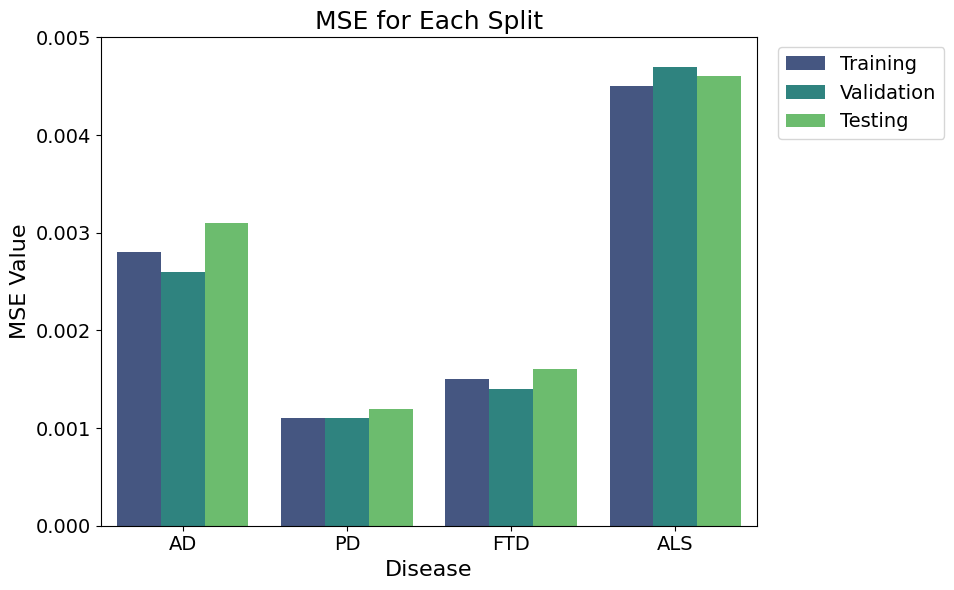

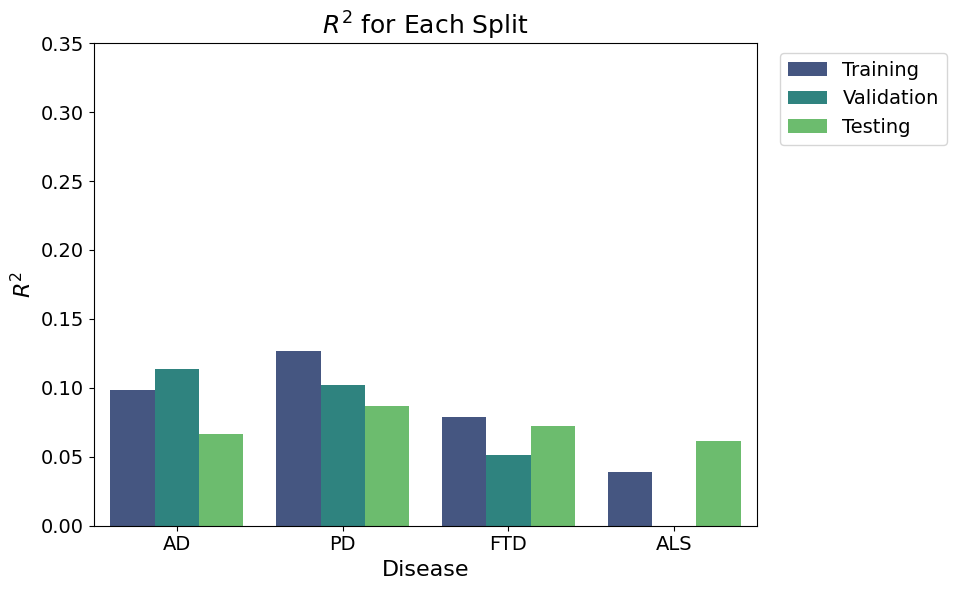

In [39]:
# plot for metrics
import seaborn as sns
# Training Metrics:
best_train = {'MSE_ad': 0.0028, 'R2_ad': 0.09833204746246338, 'MSE_pd': 0.0011, 'R2_pd': 0.12638550996780396, 'MSE_ftd': 0.0015, 'R2_ftd': 0.07882791757583618, 'MSE_als': 0.0045, 'R2_als': 0.03866219520568848}

# Val Metrics:
best_val = {'MSE_ad': 0.0026, 'R2_ad': 0.11401557922363281, 'MSE_pd': 0.0011, 'R2_pd': 0.10206347703933716, 'MSE_ftd': 0.0014, 'R2_ftd': 0.051287174224853516, 'MSE_als': 0.0047, 'R2_als': -0.006453990936279297}

# Test Metrics:
best_test = {'MSE_ad': 0.0031, 'R2_ad': 0.06658023595809937, 'MSE_pd': 0.0012, 'R2_pd': 0.0871090292930603, 'MSE_ftd': 0.0016, 'R2_ftd': 0.07268446683883667, 'MSE_als': 0.0046, 'R2_als': 0.0617215633392334}

diseases = ['AD', 'PD', 'FTD', 'ALS']

# put MSE values for all splits in a dict
all_mse = {
    'Training': [best_train[f'MSE_{d.lower()}'] for d in diseases],
    'Validation': [best_val[f'MSE_{d.lower()}'] for d in diseases],
    'Testing': [best_test[f'MSE_{d.lower()}'] for d in diseases]
}

mse_df = pd.DataFrame(all_mse, index=diseases)
mse_df.index.name = 'disease'

# melt df to get disease, splits, and mse columns
mse_melted = mse_df.reset_index().melt(
    id_vars='disease', 
    var_name='split', 
    value_name='MSE'
)

# plotting MSE
plt.figure(figsize=(10,6))
sns.barplot(x='disease', y='MSE', hue='split', data=mse_melted, palette='viridis')
plt.ylabel('MSE Value', fontsize=16)
plt.xlabel('Disease', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MSE for Each Split', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=14)
plt.ylim(0, 0.005)
plt.tight_layout()
plt.show()

# plotting R^2
# put R^2 values for all splits in a dict
all_r2 = {
    'Training': [best_train[f'R2_{d.lower()}'] for d in diseases],
    'Validation': [best_val[f'R2_{d.lower()}'] for d in diseases],
    'Testing': [best_test[f'R2_{d.lower()}'] for d in diseases]
}

r2_df = pd.DataFrame(all_r2, index=diseases)
r2_df.index.name = 'disease'

# melt df to get disease, splits, and r2 columns
r2_melted = r2_df.reset_index().melt(
    id_vars='disease', 
    var_name='split', 
    value_name='R2'
)

# plotting R^2
plt.figure(figsize=(10,6))
sns.barplot(x='disease', y='R2', hue='split', data=r2_melted, palette='viridis')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Disease', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$R^2$ for Each Split', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=14)
plt.ylim(0, 0.35)
plt.tight_layout()
plt.show()

Epoch 000 | Train: 0.9919 | Val: 1.0168 * NEW BEST
Epoch 010 | Train: 0.9764 | Val: 1.0042 * NEW BEST
Epoch 020 | Train: 0.9668 | Val: 0.9965 * NEW BEST
Epoch 030 | Train: 0.9601 | Val: 0.9929 * NEW BEST
Epoch 040 | Train: 0.9574 | Val: 0.9924 * NEW BEST
Epoch 050 | Train: 0.9492 | Val: 0.9908 * NEW BEST
Epoch 060 | Train: 0.9499 | Val: 0.9886 * NEW BEST
Epoch 070 | Train: 0.9473 | Val: 0.9853 * NEW BEST
Epoch 080 | Train: 0.9441 | Val: 0.9823 * NEW BEST
Epoch 090 | Train: 0.9430 | Val: 0.9791 * NEW BEST
Epoch 100 | Train: 0.9416 | Val: 0.9766 * NEW BEST
Epoch 110 | Train: 0.9392 | Val: 0.9740 * NEW BEST
Epoch 120 | Train: 0.9361 | Val: 0.9709 * NEW BEST
Epoch 130 | Train: 0.9359 | Val: 0.9681 * NEW BEST
Epoch 140 | Train: 0.9320 | Val: 0.9653 * NEW BEST
Epoch 150 | Train: 0.9323 | Val: 0.9626 * NEW BEST
Epoch 160 | Train: 0.9275 | Val: 0.9598 * NEW BEST
Epoch 170 | Train: 0.9311 | Val: 0.9582 * NEW BEST
Epoch 180 | Train: 0.9239 | Val: 0.9556 * NEW BEST
Epoch 190 | Train: 0.9213 | Val

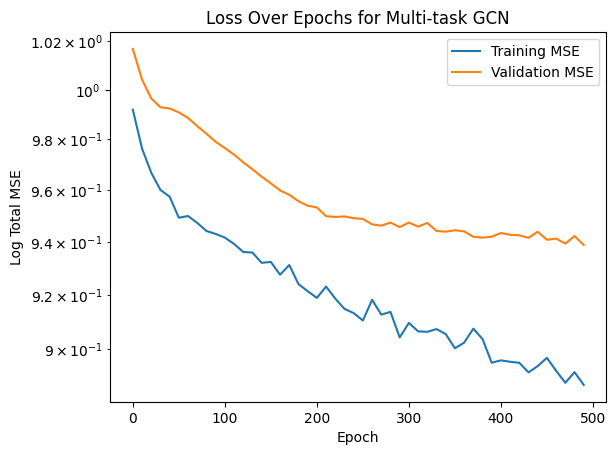

Epoch 000 | Train: 1.0140 | Val: 1.0218 * NEW BEST
Epoch 010 | Train: 0.9936 | Val: 1.0105 * NEW BEST
Epoch 020 | Train: 0.9744 | Val: 1.0049 * NEW BEST
Epoch 030 | Train: 0.9686 | Val: 1.0004 * NEW BEST
Epoch 040 | Train: 0.9609 | Val: 0.9964 * NEW BEST
Epoch 050 | Train: 0.9573 | Val: 0.9939 * NEW BEST
Epoch 060 | Train: 0.9561 | Val: 0.9913 * NEW BEST
Epoch 070 | Train: 0.9547 | Val: 0.9882 * NEW BEST
Epoch 080 | Train: 0.9529 | Val: 0.9842 * NEW BEST
Epoch 090 | Train: 0.9443 | Val: 0.9806 * NEW BEST
Epoch 100 | Train: 0.9506 | Val: 0.9797 * NEW BEST
Epoch 110 | Train: 0.9458 | Val: 0.9787 * NEW BEST
Epoch 120 | Train: 0.9430 | Val: 0.9759 * NEW BEST
Epoch 130 | Train: 0.9441 | Val: 0.9729 * NEW BEST
Epoch 140 | Train: 0.9438 | Val: 0.9707 * NEW BEST
Epoch 150 | Train: 0.9422 | Val: 0.9682 * NEW BEST
Epoch 160 | Train: 0.9406 | Val: 0.9659 * NEW BEST
Epoch 170 | Train: 0.9442 | Val: 0.9629 * NEW BEST
Epoch 180 | Train: 0.9375 | Val: 0.9611 * NEW BEST
Epoch 190 | Train: 0.9397 | Val

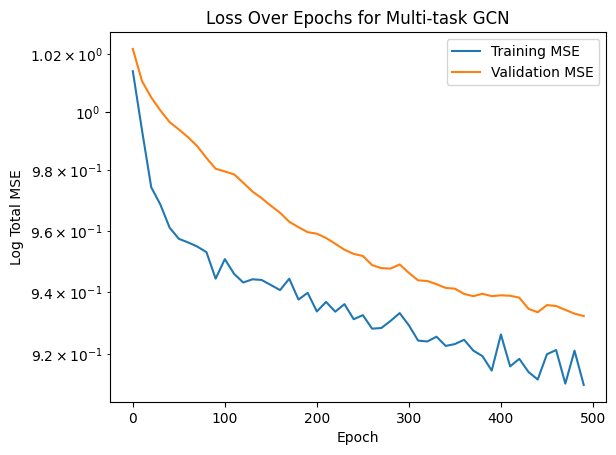

Epoch 000 | Train: 1.0247 | Val: 1.0259 * NEW BEST
Epoch 010 | Train: 0.9971 | Val: 1.0112 * NEW BEST
Epoch 020 | Train: 0.9846 | Val: 1.0032 * NEW BEST
Epoch 030 | Train: 0.9771 | Val: 0.9984 * NEW BEST
Epoch 040 | Train: 0.9725 | Val: 0.9946 * NEW BEST
Epoch 050 | Train: 0.9669 | Val: 0.9909 * NEW BEST
Epoch 060 | Train: 0.9563 | Val: 0.9885 * NEW BEST
Epoch 070 | Train: 0.9579 | Val: 0.9863 * NEW BEST
Epoch 080 | Train: 0.9578 | Val: 0.9849 * NEW BEST
Epoch 090 | Train: 0.9588 | Val: 0.9839 * NEW BEST
Epoch 100 | Train: 0.9543 | Val: 0.9831 * NEW BEST
Epoch 110 | Train: 0.9528 | Val: 0.9823 * NEW BEST
Epoch 120 | Train: 0.9543 | Val: 0.9803 * NEW BEST
Epoch 130 | Train: 0.9489 | Val: 0.9790 * NEW BEST
Epoch 140 | Train: 0.9510 | Val: 0.9775 * NEW BEST
Epoch 150 | Train: 0.9497 | Val: 0.9757 * NEW BEST
Epoch 160 | Train: 0.9473 | Val: 0.9744 * NEW BEST
Epoch 170 | Train: 0.9482 | Val: 0.9737 * NEW BEST
Epoch 180 | Train: 0.9470 | Val: 0.9733 * NEW BEST
Epoch 190 | Train: 0.9436 | Val

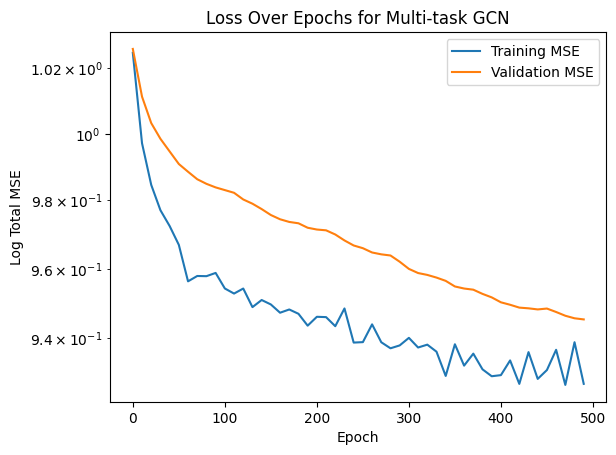

Epoch 000 | Train: 1.0463 | Val: 1.0298 * NEW BEST
Epoch 010 | Train: 1.0106 | Val: 1.0163 * NEW BEST
Epoch 020 | Train: 0.9924 | Val: 1.0103 * NEW BEST
Epoch 030 | Train: 0.9843 | Val: 1.0049 * NEW BEST
Epoch 040 | Train: 0.9750 | Val: 1.0002 * NEW BEST
Epoch 050 | Train: 0.9730 | Val: 0.9966 * NEW BEST
Epoch 060 | Train: 0.9644 | Val: 0.9949 * NEW BEST
Epoch 070 | Train: 0.9625 | Val: 0.9934 * NEW BEST
Epoch 080 | Train: 0.9577 | Val: 0.9918 * NEW BEST
Epoch 090 | Train: 0.9626 | Val: 0.9902 * NEW BEST
Epoch 100 | Train: 0.9615 | Val: 0.9891 * NEW BEST
Epoch 110 | Train: 0.9587 | Val: 0.9892
Epoch 120 | Train: 0.9575 | Val: 0.9884 * NEW BEST
Epoch 130 | Train: 0.9600 | Val: 0.9877 * NEW BEST
Epoch 140 | Train: 0.9564 | Val: 0.9863 * NEW BEST
Epoch 150 | Train: 0.9545 | Val: 0.9852 * NEW BEST
Epoch 160 | Train: 0.9533 | Val: 0.9851 * NEW BEST
Epoch 170 | Train: 0.9608 | Val: 0.9840 * NEW BEST
Epoch 180 | Train: 0.9617 | Val: 0.9834 * NEW BEST
Epoch 190 | Train: 0.9506 | Val: 0.9836
Ep

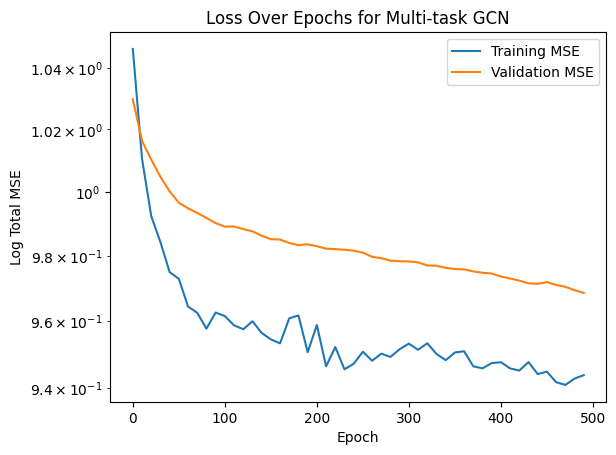

Epoch 000 | Train: 1.0108 | Val: 1.0288 * NEW BEST
Epoch 010 | Train: 0.9755 | Val: 1.0051 * NEW BEST
Epoch 020 | Train: 0.9598 | Val: 0.9942 * NEW BEST
Epoch 030 | Train: 0.9535 | Val: 0.9899 * NEW BEST
Epoch 040 | Train: 0.9478 | Val: 0.9900
Epoch 050 | Train: 0.9457 | Val: 0.9862 * NEW BEST
Epoch 060 | Train: 0.9411 | Val: 0.9816 * NEW BEST
Epoch 070 | Train: 0.9383 | Val: 0.9754 * NEW BEST
Epoch 080 | Train: 0.9353 | Val: 0.9711 * NEW BEST
Epoch 090 | Train: 0.9320 | Val: 0.9669 * NEW BEST
Epoch 100 | Train: 0.9296 | Val: 0.9627 * NEW BEST
Epoch 110 | Train: 0.9255 | Val: 0.9588 * NEW BEST
Epoch 120 | Train: 0.9237 | Val: 0.9552 * NEW BEST
Epoch 130 | Train: 0.9230 | Val: 0.9525 * NEW BEST
Epoch 140 | Train: 0.9198 | Val: 0.9510 * NEW BEST
Epoch 150 | Train: 0.9170 | Val: 0.9503 * NEW BEST
Epoch 160 | Train: 0.9151 | Val: 0.9485 * NEW BEST
Epoch 170 | Train: 0.9115 | Val: 0.9456 * NEW BEST
Epoch 180 | Train: 0.9068 | Val: 0.9458
Epoch 190 | Train: 0.9074 | Val: 0.9452 * NEW BEST
Ep

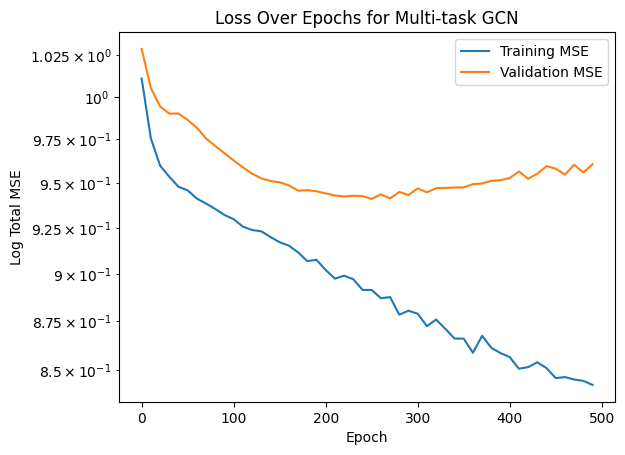

Epoch 000 | Train: 0.9922 | Val: 0.9989 * NEW BEST
Epoch 010 | Train: 0.9678 | Val: 0.9929 * NEW BEST
Epoch 020 | Train: 0.9585 | Val: 0.9945
Epoch 030 | Train: 0.9542 | Val: 0.9943
Epoch 040 | Train: 0.9492 | Val: 0.9879 * NEW BEST
Epoch 050 | Train: 0.9484 | Val: 0.9815 * NEW BEST
Epoch 060 | Train: 0.9476 | Val: 0.9782 * NEW BEST
Epoch 070 | Train: 0.9430 | Val: 0.9742 * NEW BEST
Epoch 080 | Train: 0.9392 | Val: 0.9695 * NEW BEST
Epoch 090 | Train: 0.9368 | Val: 0.9649 * NEW BEST
Epoch 100 | Train: 0.9338 | Val: 0.9608 * NEW BEST
Epoch 110 | Train: 0.9321 | Val: 0.9554 * NEW BEST
Epoch 120 | Train: 0.9295 | Val: 0.9515 * NEW BEST
Epoch 130 | Train: 0.9234 | Val: 0.9499 * NEW BEST
Epoch 140 | Train: 0.9245 | Val: 0.9472 * NEW BEST
Epoch 150 | Train: 0.9245 | Val: 0.9448 * NEW BEST
Epoch 160 | Train: 0.9263 | Val: 0.9436 * NEW BEST
Epoch 170 | Train: 0.9207 | Val: 0.9421 * NEW BEST
Epoch 180 | Train: 0.9186 | Val: 0.9387 * NEW BEST
Epoch 190 | Train: 0.9121 | Val: 0.9361 * NEW BEST
Ep

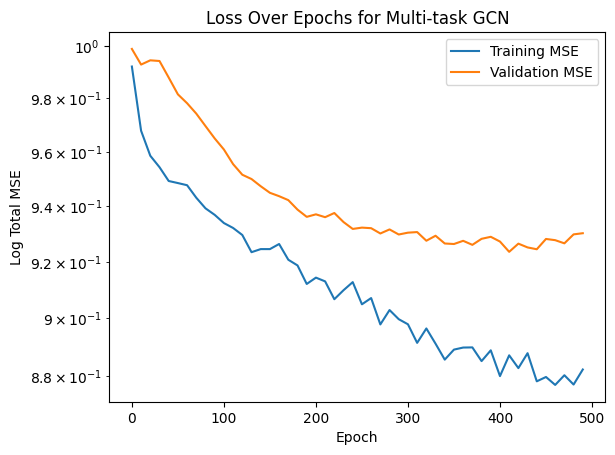

Epoch 000 | Train: 0.9961 | Val: 1.0048 * NEW BEST
Epoch 010 | Train: 0.9706 | Val: 1.0032 * NEW BEST
Epoch 020 | Train: 0.9650 | Val: 0.9988 * NEW BEST
Epoch 030 | Train: 0.9594 | Val: 0.9964 * NEW BEST
Epoch 040 | Train: 0.9577 | Val: 0.9947 * NEW BEST
Epoch 050 | Train: 0.9516 | Val: 0.9886 * NEW BEST
Epoch 060 | Train: 0.9466 | Val: 0.9827 * NEW BEST
Epoch 070 | Train: 0.9491 | Val: 0.9788 * NEW BEST
Epoch 080 | Train: 0.9407 | Val: 0.9772 * NEW BEST
Epoch 090 | Train: 0.9441 | Val: 0.9750 * NEW BEST
Epoch 100 | Train: 0.9437 | Val: 0.9718 * NEW BEST
Epoch 110 | Train: 0.9414 | Val: 0.9704 * NEW BEST
Epoch 120 | Train: 0.9393 | Val: 0.9669 * NEW BEST
Epoch 130 | Train: 0.9341 | Val: 0.9649 * NEW BEST
Epoch 140 | Train: 0.9390 | Val: 0.9617 * NEW BEST
Epoch 150 | Train: 0.9358 | Val: 0.9592 * NEW BEST
Epoch 160 | Train: 0.9352 | Val: 0.9578 * NEW BEST
Epoch 170 | Train: 0.9341 | Val: 0.9551 * NEW BEST
Epoch 180 | Train: 0.9323 | Val: 0.9538 * NEW BEST
Epoch 190 | Train: 0.9340 | Val

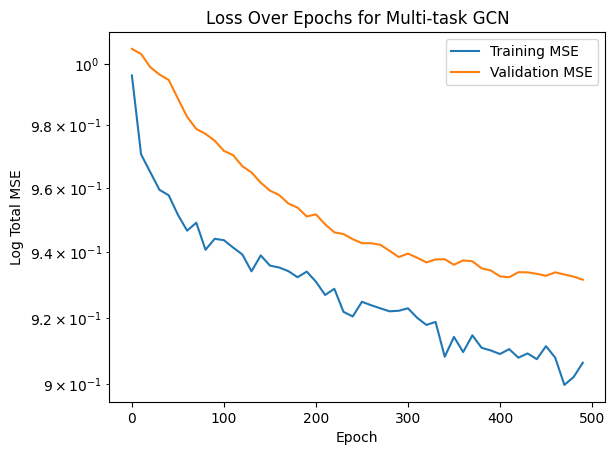

Epoch 000 | Train: 1.0025 | Val: 1.0204 * NEW BEST
Epoch 010 | Train: 0.9789 | Val: 0.9949 * NEW BEST
Epoch 020 | Train: 0.9660 | Val: 0.9874 * NEW BEST
Epoch 030 | Train: 0.9624 | Val: 0.9843 * NEW BEST
Epoch 040 | Train: 0.9543 | Val: 0.9834 * NEW BEST
Epoch 050 | Train: 0.9560 | Val: 0.9830 * NEW BEST
Epoch 060 | Train: 0.9592 | Val: 0.9809 * NEW BEST
Epoch 070 | Train: 0.9506 | Val: 0.9788 * NEW BEST
Epoch 080 | Train: 0.9569 | Val: 0.9763 * NEW BEST
Epoch 090 | Train: 0.9565 | Val: 0.9744 * NEW BEST
Epoch 100 | Train: 0.9467 | Val: 0.9730 * NEW BEST
Epoch 110 | Train: 0.9578 | Val: 0.9717 * NEW BEST
Epoch 120 | Train: 0.9427 | Val: 0.9709 * NEW BEST
Epoch 130 | Train: 0.9490 | Val: 0.9693 * NEW BEST
Epoch 140 | Train: 0.9455 | Val: 0.9681 * NEW BEST
Epoch 150 | Train: 0.9455 | Val: 0.9667 * NEW BEST
Epoch 160 | Train: 0.9439 | Val: 0.9657 * NEW BEST
Epoch 170 | Train: 0.9425 | Val: 0.9654 * NEW BEST
Epoch 180 | Train: 0.9415 | Val: 0.9634 * NEW BEST
Epoch 190 | Train: 0.9436 | Val

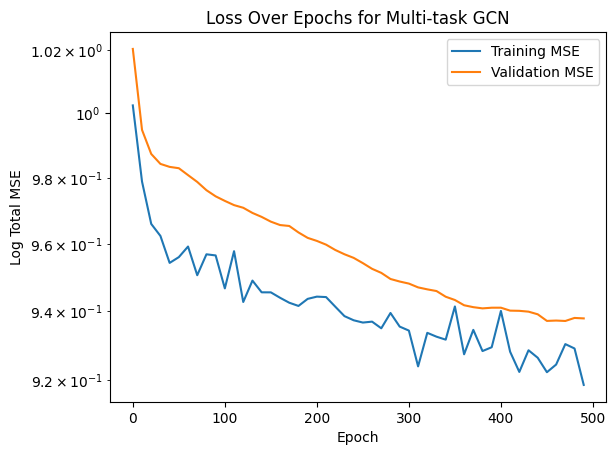

Epoch 000 | Train: 0.9903 | Val: 1.0189 * NEW BEST
Epoch 010 | Train: 0.9587 | Val: 1.0033 * NEW BEST
Epoch 020 | Train: 0.9486 | Val: 0.9926 * NEW BEST
Epoch 030 | Train: 0.9419 | Val: 0.9793 * NEW BEST
Epoch 040 | Train: 0.9343 | Val: 0.9706 * NEW BEST
Epoch 050 | Train: 0.9307 | Val: 0.9625 * NEW BEST
Epoch 060 | Train: 0.9263 | Val: 0.9581 * NEW BEST
Epoch 070 | Train: 0.9209 | Val: 0.9543 * NEW BEST
Epoch 080 | Train: 0.9153 | Val: 0.9501 * NEW BEST
Epoch 090 | Train: 0.9097 | Val: 0.9480 * NEW BEST
Epoch 100 | Train: 0.9073 | Val: 0.9450 * NEW BEST
Epoch 110 | Train: 0.9032 | Val: 0.9445 * NEW BEST
Epoch 120 | Train: 0.8972 | Val: 0.9432 * NEW BEST
Epoch 130 | Train: 0.8925 | Val: 0.9428 * NEW BEST
Epoch 140 | Train: 0.8878 | Val: 0.9395 * NEW BEST
Epoch 150 | Train: 0.8828 | Val: 0.9397
Epoch 160 | Train: 0.8823 | Val: 0.9404
Epoch 170 | Train: 0.8740 | Val: 0.9418
Epoch 180 | Train: 0.8709 | Val: 0.9378 * NEW BEST
Epoch 190 | Train: 0.8667 | Val: 0.9430
Epoch 200 | Train: 0.864

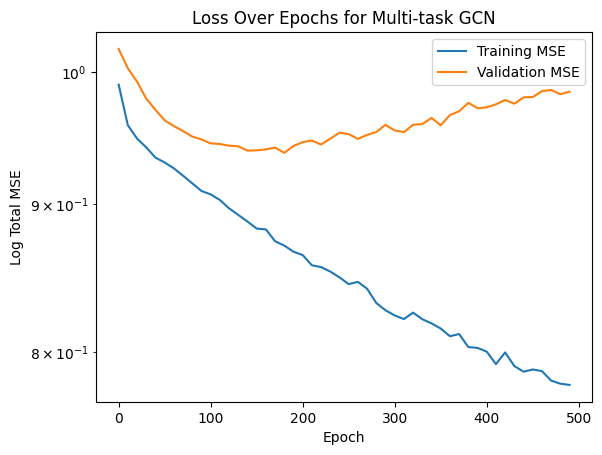

Epoch 000 | Train: 0.9928 | Val: 1.0083 * NEW BEST
Epoch 010 | Train: 0.9639 | Val: 1.0064 * NEW BEST
Epoch 020 | Train: 0.9553 | Val: 0.9946 * NEW BEST
Epoch 030 | Train: 0.9451 | Val: 0.9851 * NEW BEST
Epoch 040 | Train: 0.9410 | Val: 0.9760 * NEW BEST
Epoch 050 | Train: 0.9391 | Val: 0.9690 * NEW BEST
Epoch 060 | Train: 0.9345 | Val: 0.9613 * NEW BEST
Epoch 070 | Train: 0.9314 | Val: 0.9573 * NEW BEST
Epoch 080 | Train: 0.9295 | Val: 0.9530 * NEW BEST
Epoch 090 | Train: 0.9235 | Val: 0.9500 * NEW BEST
Epoch 100 | Train: 0.9214 | Val: 0.9467 * NEW BEST
Epoch 110 | Train: 0.9198 | Val: 0.9446 * NEW BEST
Epoch 120 | Train: 0.9127 | Val: 0.9439 * NEW BEST
Epoch 130 | Train: 0.9051 | Val: 0.9395 * NEW BEST
Epoch 140 | Train: 0.9052 | Val: 0.9408
Epoch 150 | Train: 0.9024 | Val: 0.9391 * NEW BEST
Epoch 160 | Train: 0.9017 | Val: 0.9360 * NEW BEST
Epoch 170 | Train: 0.8971 | Val: 0.9347 * NEW BEST
Epoch 180 | Train: 0.8988 | Val: 0.9353
Epoch 190 | Train: 0.8967 | Val: 0.9357
Epoch 200 | T

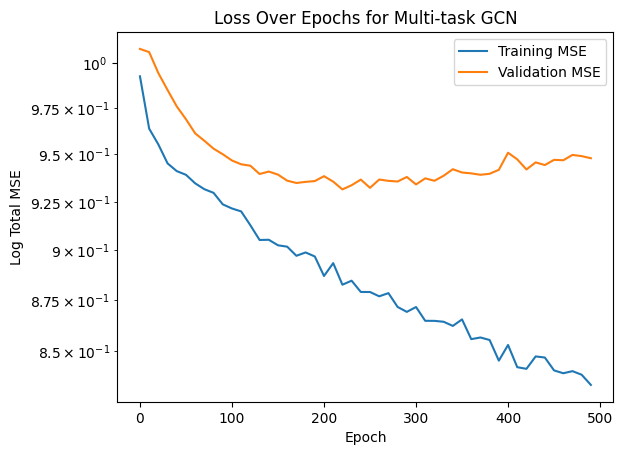

Epoch 000 | Train: 1.0029 | Val: 1.0131 * NEW BEST
Epoch 010 | Train: 0.9667 | Val: 1.0037 * NEW BEST
Epoch 020 | Train: 0.9584 | Val: 0.9950 * NEW BEST
Epoch 030 | Train: 0.9516 | Val: 0.9892 * NEW BEST
Epoch 040 | Train: 0.9447 | Val: 0.9796 * NEW BEST
Epoch 050 | Train: 0.9413 | Val: 0.9709 * NEW BEST
Epoch 060 | Train: 0.9434 | Val: 0.9660 * NEW BEST
Epoch 070 | Train: 0.9400 | Val: 0.9613 * NEW BEST
Epoch 080 | Train: 0.9341 | Val: 0.9569 * NEW BEST
Epoch 090 | Train: 0.9335 | Val: 0.9528 * NEW BEST
Epoch 100 | Train: 0.9344 | Val: 0.9505 * NEW BEST
Epoch 110 | Train: 0.9285 | Val: 0.9494 * NEW BEST
Epoch 120 | Train: 0.9238 | Val: 0.9440 * NEW BEST
Epoch 130 | Train: 0.9240 | Val: 0.9434 * NEW BEST
Epoch 140 | Train: 0.9220 | Val: 0.9400 * NEW BEST
Epoch 150 | Train: 0.9257 | Val: 0.9393 * NEW BEST
Epoch 160 | Train: 0.9125 | Val: 0.9354 * NEW BEST
Epoch 170 | Train: 0.9137 | Val: 0.9367
Epoch 180 | Train: 0.9140 | Val: 0.9343 * NEW BEST
Epoch 190 | Train: 0.9080 | Val: 0.9331 * 

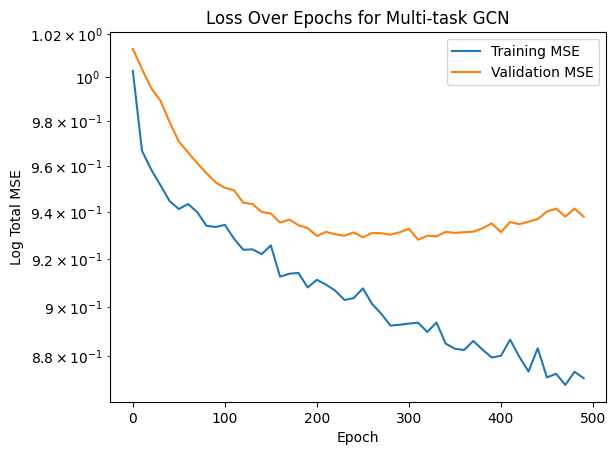

Epoch 000 | Train: 1.0055 | Val: 1.0175 * NEW BEST
Epoch 010 | Train: 0.9709 | Val: 0.9959 * NEW BEST
Epoch 020 | Train: 0.9589 | Val: 0.9945 * NEW BEST
Epoch 030 | Train: 0.9533 | Val: 0.9904 * NEW BEST
Epoch 040 | Train: 0.9498 | Val: 0.9839 * NEW BEST
Epoch 050 | Train: 0.9463 | Val: 0.9766 * NEW BEST
Epoch 060 | Train: 0.9461 | Val: 0.9723 * NEW BEST
Epoch 070 | Train: 0.9438 | Val: 0.9707 * NEW BEST
Epoch 080 | Train: 0.9394 | Val: 0.9671 * NEW BEST
Epoch 090 | Train: 0.9364 | Val: 0.9643 * NEW BEST
Epoch 100 | Train: 0.9408 | Val: 0.9612 * NEW BEST
Epoch 110 | Train: 0.9416 | Val: 0.9588 * NEW BEST
Epoch 120 | Train: 0.9401 | Val: 0.9554 * NEW BEST
Epoch 130 | Train: 0.9329 | Val: 0.9526 * NEW BEST
Epoch 140 | Train: 0.9405 | Val: 0.9509 * NEW BEST
Epoch 150 | Train: 0.9386 | Val: 0.9496 * NEW BEST
Epoch 160 | Train: 0.9287 | Val: 0.9469 * NEW BEST
Epoch 170 | Train: 0.9299 | Val: 0.9433 * NEW BEST
Epoch 180 | Train: 0.9303 | Val: 0.9420 * NEW BEST
Epoch 190 | Train: 0.9266 | Val

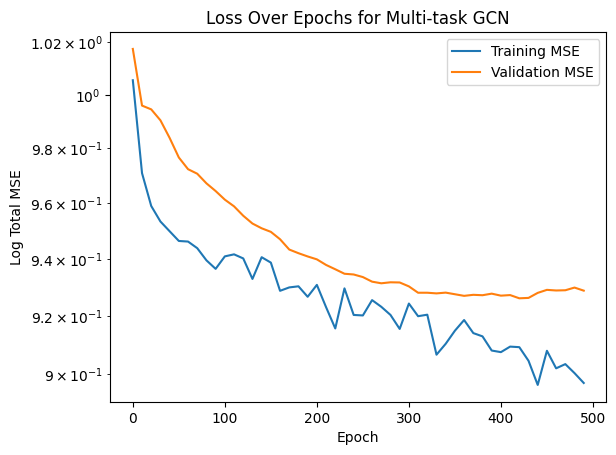

Epoch 000 | Train: 1.0146 | Val: 1.0231 * NEW BEST
Epoch 010 | Train: 0.9953 | Val: 1.0077 * NEW BEST
Epoch 020 | Train: 0.9852 | Val: 1.0008 * NEW BEST
Epoch 030 | Train: 0.9781 | Val: 0.9974 * NEW BEST
Epoch 040 | Train: 0.9700 | Val: 0.9954 * NEW BEST
Epoch 050 | Train: 0.9669 | Val: 0.9945 * NEW BEST
Epoch 060 | Train: 0.9636 | Val: 0.9942 * NEW BEST
Epoch 070 | Train: 0.9620 | Val: 0.9941 * NEW BEST
Epoch 080 | Train: 0.9595 | Val: 0.9934 * NEW BEST
Epoch 090 | Train: 0.9561 | Val: 0.9923 * NEW BEST
Epoch 100 | Train: 0.9573 | Val: 0.9911 * NEW BEST
Epoch 110 | Train: 0.9510 | Val: 0.9893 * NEW BEST
Epoch 120 | Train: 0.9540 | Val: 0.9881 * NEW BEST
Epoch 130 | Train: 0.9508 | Val: 0.9865 * NEW BEST
Epoch 140 | Train: 0.9474 | Val: 0.9840 * NEW BEST
Epoch 150 | Train: 0.9465 | Val: 0.9822 * NEW BEST
Epoch 160 | Train: 0.9469 | Val: 0.9809 * NEW BEST
Epoch 170 | Train: 0.9444 | Val: 0.9791 * NEW BEST
Epoch 180 | Train: 0.9421 | Val: 0.9782 * NEW BEST
Epoch 190 | Train: 0.9410 | Val

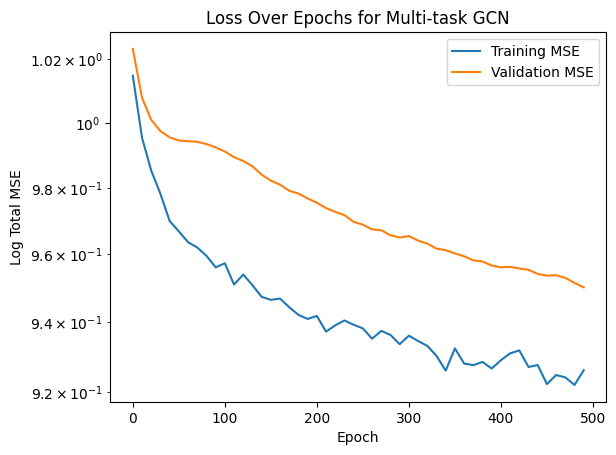

Epoch 000 | Train: 0.9985 | Val: 1.0358 * NEW BEST
Epoch 010 | Train: 0.9898 | Val: 1.0272 * NEW BEST
Epoch 020 | Train: 0.9839 | Val: 1.0188 * NEW BEST
Epoch 030 | Train: 0.9717 | Val: 1.0115 * NEW BEST
Epoch 040 | Train: 0.9708 | Val: 1.0056 * NEW BEST
Epoch 050 | Train: 0.9699 | Val: 1.0013 * NEW BEST
Epoch 060 | Train: 0.9644 | Val: 0.9982 * NEW BEST
Epoch 070 | Train: 0.9593 | Val: 0.9963 * NEW BEST
Epoch 080 | Train: 0.9569 | Val: 0.9954 * NEW BEST
Epoch 090 | Train: 0.9564 | Val: 0.9946 * NEW BEST
Epoch 100 | Train: 0.9575 | Val: 0.9932 * NEW BEST
Epoch 110 | Train: 0.9554 | Val: 0.9922 * NEW BEST
Epoch 120 | Train: 0.9539 | Val: 0.9904 * NEW BEST
Epoch 130 | Train: 0.9537 | Val: 0.9883 * NEW BEST
Epoch 140 | Train: 0.9518 | Val: 0.9868 * NEW BEST
Epoch 150 | Train: 0.9512 | Val: 0.9856 * NEW BEST
Epoch 160 | Train: 0.9455 | Val: 0.9836 * NEW BEST
Epoch 170 | Train: 0.9455 | Val: 0.9826 * NEW BEST
Epoch 180 | Train: 0.9464 | Val: 0.9819 * NEW BEST
Epoch 190 | Train: 0.9470 | Val

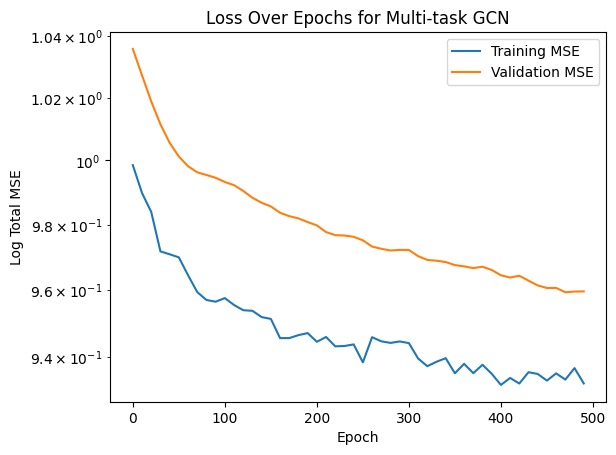

Epoch 000 | Train: 1.0230 | Val: 1.0310 * NEW BEST
Epoch 010 | Train: 1.0150 | Val: 1.0230 * NEW BEST
Epoch 020 | Train: 0.9980 | Val: 1.0191 * NEW BEST
Epoch 030 | Train: 0.9907 | Val: 1.0170 * NEW BEST
Epoch 040 | Train: 0.9839 | Val: 1.0151 * NEW BEST
Epoch 050 | Train: 0.9848 | Val: 1.0130 * NEW BEST
Epoch 060 | Train: 0.9756 | Val: 1.0108 * NEW BEST
Epoch 070 | Train: 0.9774 | Val: 1.0084 * NEW BEST
Epoch 080 | Train: 0.9707 | Val: 1.0064 * NEW BEST
Epoch 090 | Train: 0.9718 | Val: 1.0047 * NEW BEST
Epoch 100 | Train: 0.9668 | Val: 1.0034 * NEW BEST
Epoch 110 | Train: 0.9676 | Val: 1.0017 * NEW BEST
Epoch 120 | Train: 0.9671 | Val: 1.0003 * NEW BEST
Epoch 130 | Train: 0.9671 | Val: 0.9988 * NEW BEST
Epoch 140 | Train: 0.9634 | Val: 0.9974 * NEW BEST
Epoch 150 | Train: 0.9544 | Val: 0.9964 * NEW BEST
Epoch 160 | Train: 0.9583 | Val: 0.9949 * NEW BEST
Epoch 170 | Train: 0.9609 | Val: 0.9934 * NEW BEST
Epoch 180 | Train: 0.9606 | Val: 0.9920 * NEW BEST
Epoch 190 | Train: 0.9554 | Val

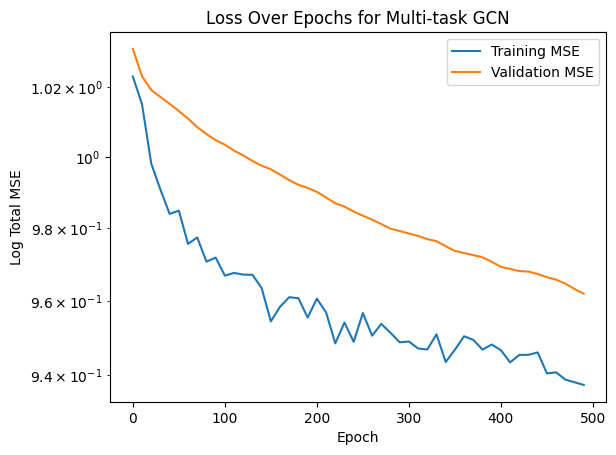

Epoch 000 | Train: 1.0134 | Val: 1.0309 * NEW BEST
Epoch 010 | Train: 0.9951 | Val: 1.0253 * NEW BEST
Epoch 020 | Train: 0.9962 | Val: 1.0191 * NEW BEST
Epoch 030 | Train: 0.9915 | Val: 1.0141 * NEW BEST
Epoch 040 | Train: 0.9784 | Val: 1.0104 * NEW BEST
Epoch 050 | Train: 0.9725 | Val: 1.0084 * NEW BEST
Epoch 060 | Train: 0.9751 | Val: 1.0074 * NEW BEST
Epoch 070 | Train: 0.9746 | Val: 1.0058 * NEW BEST
Epoch 080 | Train: 0.9755 | Val: 1.0042 * NEW BEST
Epoch 090 | Train: 0.9644 | Val: 1.0029 * NEW BEST
Epoch 100 | Train: 0.9673 | Val: 1.0020 * NEW BEST
Epoch 110 | Train: 0.9664 | Val: 1.0001 * NEW BEST
Epoch 120 | Train: 0.9653 | Val: 0.9986 * NEW BEST
Epoch 130 | Train: 0.9669 | Val: 0.9977 * NEW BEST
Epoch 140 | Train: 0.9689 | Val: 0.9968 * NEW BEST
Epoch 150 | Train: 0.9687 | Val: 0.9958 * NEW BEST
Epoch 160 | Train: 0.9648 | Val: 0.9951 * NEW BEST
Epoch 170 | Train: 0.9622 | Val: 0.9941 * NEW BEST
Epoch 180 | Train: 0.9615 | Val: 0.9930 * NEW BEST
Epoch 190 | Train: 0.9606 | Val

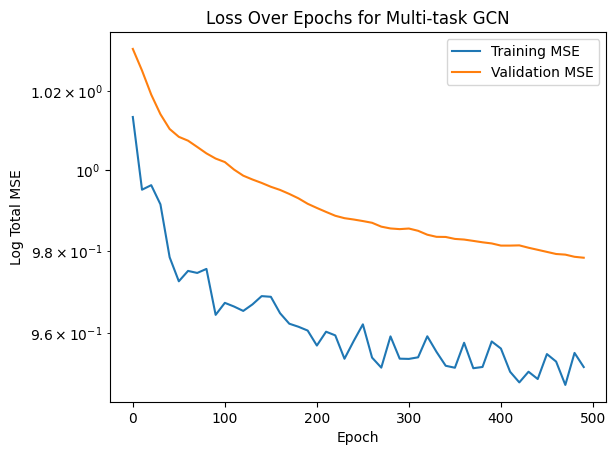

Epoch 000 | Train: 0.9968 | Val: 1.0335 * NEW BEST
Epoch 010 | Train: 0.9808 | Val: 1.0178 * NEW BEST
Epoch 020 | Train: 0.9699 | Val: 1.0082 * NEW BEST
Epoch 030 | Train: 0.9604 | Val: 1.0025 * NEW BEST
Epoch 040 | Train: 0.9572 | Val: 0.9988 * NEW BEST
Epoch 050 | Train: 0.9527 | Val: 0.9964 * NEW BEST
Epoch 060 | Train: 0.9481 | Val: 0.9930 * NEW BEST
Epoch 070 | Train: 0.9465 | Val: 0.9889 * NEW BEST
Epoch 080 | Train: 0.9435 | Val: 0.9838 * NEW BEST
Epoch 090 | Train: 0.9425 | Val: 0.9803 * NEW BEST
Epoch 100 | Train: 0.9399 | Val: 0.9773 * NEW BEST
Epoch 110 | Train: 0.9372 | Val: 0.9750 * NEW BEST
Epoch 120 | Train: 0.9355 | Val: 0.9722 * NEW BEST
Epoch 130 | Train: 0.9371 | Val: 0.9699 * NEW BEST
Epoch 140 | Train: 0.9324 | Val: 0.9685 * NEW BEST
Epoch 150 | Train: 0.9300 | Val: 0.9664 * NEW BEST
Epoch 160 | Train: 0.9325 | Val: 0.9639 * NEW BEST
Epoch 170 | Train: 0.9281 | Val: 0.9617 * NEW BEST
Epoch 180 | Train: 0.9294 | Val: 0.9609 * NEW BEST
Epoch 190 | Train: 0.9252 | Val

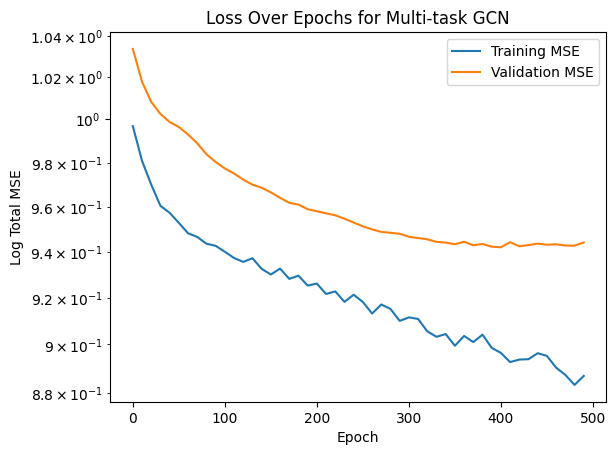

Epoch 000 | Train: 0.9963 | Val: 1.0142 * NEW BEST
Epoch 010 | Train: 0.9768 | Val: 1.0030 * NEW BEST
Epoch 020 | Train: 0.9690 | Val: 0.9985 * NEW BEST
Epoch 030 | Train: 0.9628 | Val: 0.9961 * NEW BEST
Epoch 040 | Train: 0.9567 | Val: 0.9945 * NEW BEST
Epoch 050 | Train: 0.9572 | Val: 0.9940 * NEW BEST
Epoch 060 | Train: 0.9558 | Val: 0.9940 * NEW BEST
Epoch 070 | Train: 0.9499 | Val: 0.9923 * NEW BEST
Epoch 080 | Train: 0.9525 | Val: 0.9895 * NEW BEST
Epoch 090 | Train: 0.9512 | Val: 0.9878 * NEW BEST
Epoch 100 | Train: 0.9492 | Val: 0.9850 * NEW BEST
Epoch 110 | Train: 0.9473 | Val: 0.9828 * NEW BEST
Epoch 120 | Train: 0.9455 | Val: 0.9810 * NEW BEST
Epoch 130 | Train: 0.9450 | Val: 0.9792 * NEW BEST
Epoch 140 | Train: 0.9408 | Val: 0.9770 * NEW BEST
Epoch 150 | Train: 0.9395 | Val: 0.9756 * NEW BEST
Epoch 160 | Train: 0.9407 | Val: 0.9741 * NEW BEST
Epoch 170 | Train: 0.9404 | Val: 0.9722 * NEW BEST
Epoch 180 | Train: 0.9424 | Val: 0.9705 * NEW BEST
Epoch 190 | Train: 0.9354 | Val

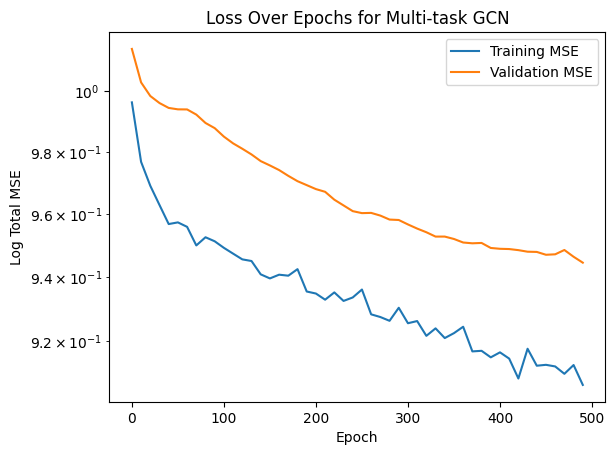

Epoch 000 | Train: 1.0070 | Val: 1.0376 * NEW BEST
Epoch 010 | Train: 0.9859 | Val: 1.0132 * NEW BEST
Epoch 020 | Train: 0.9801 | Val: 1.0025 * NEW BEST
Epoch 030 | Train: 0.9654 | Val: 0.9980 * NEW BEST
Epoch 040 | Train: 0.9630 | Val: 0.9962 * NEW BEST
Epoch 050 | Train: 0.9615 | Val: 0.9941 * NEW BEST
Epoch 060 | Train: 0.9533 | Val: 0.9921 * NEW BEST
Epoch 070 | Train: 0.9558 | Val: 0.9892 * NEW BEST
Epoch 080 | Train: 0.9515 | Val: 0.9865 * NEW BEST
Epoch 090 | Train: 0.9544 | Val: 0.9836 * NEW BEST
Epoch 100 | Train: 0.9532 | Val: 0.9807 * NEW BEST
Epoch 110 | Train: 0.9479 | Val: 0.9786 * NEW BEST
Epoch 120 | Train: 0.9489 | Val: 0.9768 * NEW BEST
Epoch 130 | Train: 0.9439 | Val: 0.9755 * NEW BEST
Epoch 140 | Train: 0.9458 | Val: 0.9737 * NEW BEST
Epoch 150 | Train: 0.9449 | Val: 0.9717 * NEW BEST
Epoch 160 | Train: 0.9406 | Val: 0.9700 * NEW BEST
Epoch 170 | Train: 0.9430 | Val: 0.9692 * NEW BEST
Epoch 180 | Train: 0.9394 | Val: 0.9677 * NEW BEST
Epoch 190 | Train: 0.9413 | Val

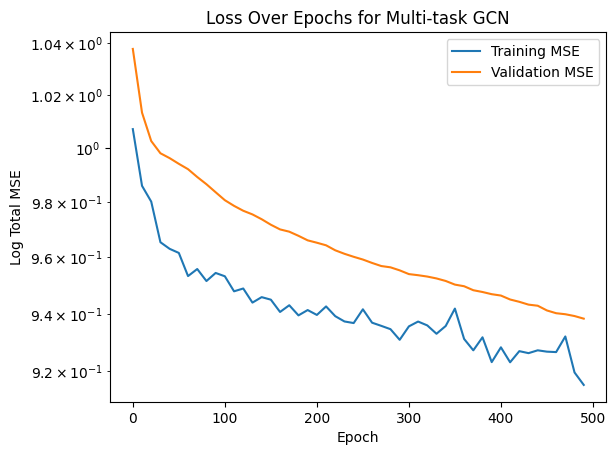

Epoch 000 | Train: 1.0179 | Val: 1.0574 * NEW BEST
Epoch 010 | Train: 0.9958 | Val: 1.0314 * NEW BEST
Epoch 020 | Train: 0.9780 | Val: 1.0181 * NEW BEST
Epoch 030 | Train: 0.9744 | Val: 1.0112 * NEW BEST
Epoch 040 | Train: 0.9686 | Val: 1.0071 * NEW BEST
Epoch 050 | Train: 0.9688 | Val: 1.0039 * NEW BEST
Epoch 060 | Train: 0.9614 | Val: 1.0006 * NEW BEST
Epoch 070 | Train: 0.9623 | Val: 0.9971 * NEW BEST
Epoch 080 | Train: 0.9529 | Val: 0.9943 * NEW BEST
Epoch 090 | Train: 0.9607 | Val: 0.9924 * NEW BEST
Epoch 100 | Train: 0.9557 | Val: 0.9904 * NEW BEST
Epoch 110 | Train: 0.9519 | Val: 0.9885 * NEW BEST
Epoch 120 | Train: 0.9517 | Val: 0.9864 * NEW BEST
Epoch 130 | Train: 0.9507 | Val: 0.9844 * NEW BEST
Epoch 140 | Train: 0.9525 | Val: 0.9829 * NEW BEST
Epoch 150 | Train: 0.9541 | Val: 0.9817 * NEW BEST
Epoch 160 | Train: 0.9567 | Val: 0.9810 * NEW BEST
Epoch 170 | Train: 0.9501 | Val: 0.9800 * NEW BEST
Epoch 180 | Train: 0.9532 | Val: 0.9791 * NEW BEST
Epoch 190 | Train: 0.9503 | Val

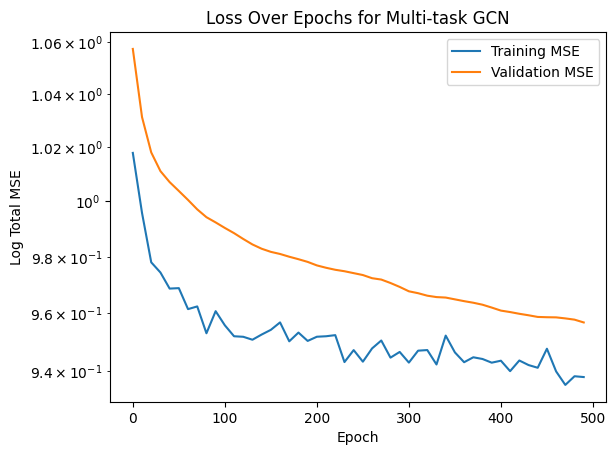

Epoch 000 | Train: 0.9925 | Val: 1.0146 * NEW BEST
Epoch 010 | Train: 0.9642 | Val: 0.9962 * NEW BEST
Epoch 020 | Train: 0.9533 | Val: 0.9928 * NEW BEST
Epoch 030 | Train: 0.9493 | Val: 0.9909 * NEW BEST
Epoch 040 | Train: 0.9457 | Val: 0.9846 * NEW BEST
Epoch 050 | Train: 0.9399 | Val: 0.9784 * NEW BEST
Epoch 060 | Train: 0.9388 | Val: 0.9733 * NEW BEST
Epoch 070 | Train: 0.9346 | Val: 0.9702 * NEW BEST
Epoch 080 | Train: 0.9329 | Val: 0.9669 * NEW BEST
Epoch 090 | Train: 0.9303 | Val: 0.9626 * NEW BEST
Epoch 100 | Train: 0.9279 | Val: 0.9604 * NEW BEST
Epoch 110 | Train: 0.9248 | Val: 0.9571 * NEW BEST
Epoch 120 | Train: 0.9235 | Val: 0.9540 * NEW BEST
Epoch 130 | Train: 0.9218 | Val: 0.9525 * NEW BEST
Epoch 140 | Train: 0.9195 | Val: 0.9516 * NEW BEST
Epoch 150 | Train: 0.9141 | Val: 0.9493 * NEW BEST
Epoch 160 | Train: 0.9162 | Val: 0.9473 * NEW BEST
Epoch 170 | Train: 0.9098 | Val: 0.9474
Epoch 180 | Train: 0.9024 | Val: 0.9461 * NEW BEST
Epoch 190 | Train: 0.9040 | Val: 0.9455 * 

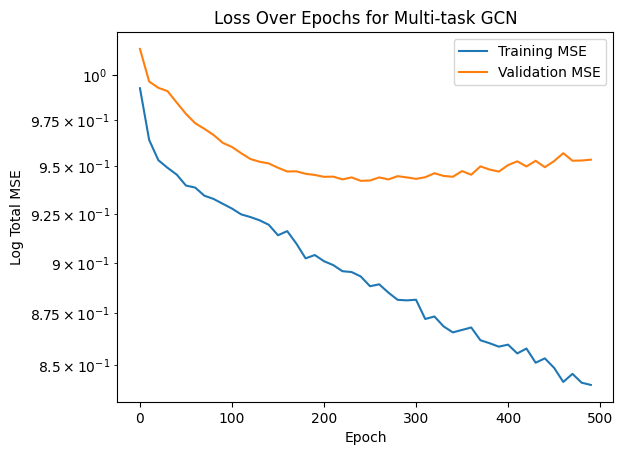

Epoch 000 | Train: 0.9850 | Val: 1.0135 * NEW BEST
Epoch 010 | Train: 0.9627 | Val: 0.9975 * NEW BEST
Epoch 020 | Train: 0.9526 | Val: 0.9950 * NEW BEST
Epoch 030 | Train: 0.9523 | Val: 0.9937 * NEW BEST
Epoch 040 | Train: 0.9458 | Val: 0.9876 * NEW BEST
Epoch 050 | Train: 0.9449 | Val: 0.9808 * NEW BEST
Epoch 060 | Train: 0.9394 | Val: 0.9759 * NEW BEST
Epoch 070 | Train: 0.9415 | Val: 0.9727 * NEW BEST
Epoch 080 | Train: 0.9340 | Val: 0.9700 * NEW BEST
Epoch 090 | Train: 0.9363 | Val: 0.9656 * NEW BEST
Epoch 100 | Train: 0.9321 | Val: 0.9625 * NEW BEST
Epoch 110 | Train: 0.9341 | Val: 0.9598 * NEW BEST
Epoch 120 | Train: 0.9281 | Val: 0.9572 * NEW BEST
Epoch 130 | Train: 0.9271 | Val: 0.9549 * NEW BEST
Epoch 140 | Train: 0.9272 | Val: 0.9534 * NEW BEST
Epoch 150 | Train: 0.9229 | Val: 0.9518 * NEW BEST
Epoch 160 | Train: 0.9258 | Val: 0.9511 * NEW BEST
Epoch 170 | Train: 0.9209 | Val: 0.9494 * NEW BEST
Epoch 180 | Train: 0.9172 | Val: 0.9467 * NEW BEST
Epoch 190 | Train: 0.9188 | Val

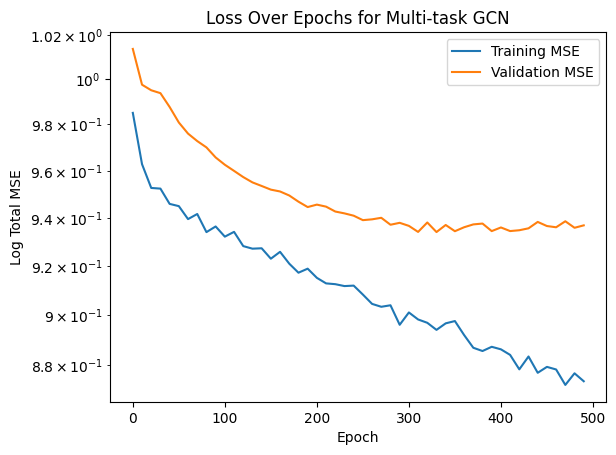

Epoch 000 | Train: 0.9897 | Val: 1.0175 * NEW BEST
Epoch 010 | Train: 0.9681 | Val: 1.0061 * NEW BEST
Epoch 020 | Train: 0.9603 | Val: 0.9995 * NEW BEST
Epoch 030 | Train: 0.9559 | Val: 0.9954 * NEW BEST
Epoch 040 | Train: 0.9525 | Val: 0.9909 * NEW BEST
Epoch 050 | Train: 0.9502 | Val: 0.9862 * NEW BEST
Epoch 060 | Train: 0.9455 | Val: 0.9821 * NEW BEST
Epoch 070 | Train: 0.9432 | Val: 0.9788 * NEW BEST
Epoch 080 | Train: 0.9419 | Val: 0.9752 * NEW BEST
Epoch 090 | Train: 0.9444 | Val: 0.9722 * NEW BEST
Epoch 100 | Train: 0.9372 | Val: 0.9693 * NEW BEST
Epoch 110 | Train: 0.9435 | Val: 0.9659 * NEW BEST
Epoch 120 | Train: 0.9417 | Val: 0.9624 * NEW BEST
Epoch 130 | Train: 0.9334 | Val: 0.9605 * NEW BEST
Epoch 140 | Train: 0.9323 | Val: 0.9589 * NEW BEST
Epoch 150 | Train: 0.9309 | Val: 0.9561 * NEW BEST
Epoch 160 | Train: 0.9331 | Val: 0.9537 * NEW BEST
Epoch 170 | Train: 0.9287 | Val: 0.9517 * NEW BEST
Epoch 180 | Train: 0.9293 | Val: 0.9512 * NEW BEST
Epoch 190 | Train: 0.9250 | Val

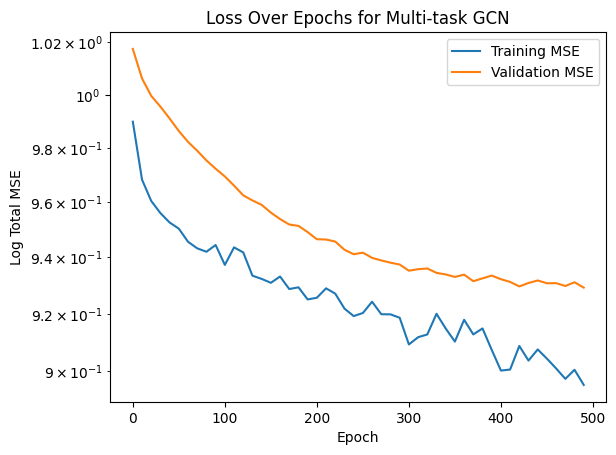

Epoch 000 | Train: 0.9966 | Val: 1.0256 * NEW BEST
Epoch 010 | Train: 0.9716 | Val: 1.0065 * NEW BEST
Epoch 020 | Train: 0.9642 | Val: 0.9974 * NEW BEST
Epoch 030 | Train: 0.9517 | Val: 0.9943 * NEW BEST
Epoch 040 | Train: 0.9543 | Val: 0.9905 * NEW BEST
Epoch 050 | Train: 0.9522 | Val: 0.9865 * NEW BEST
Epoch 060 | Train: 0.9498 | Val: 0.9830 * NEW BEST
Epoch 070 | Train: 0.9515 | Val: 0.9798 * NEW BEST
Epoch 080 | Train: 0.9516 | Val: 0.9769 * NEW BEST
Epoch 090 | Train: 0.9476 | Val: 0.9748 * NEW BEST
Epoch 100 | Train: 0.9436 | Val: 0.9723 * NEW BEST
Epoch 110 | Train: 0.9474 | Val: 0.9703 * NEW BEST
Epoch 120 | Train: 0.9441 | Val: 0.9687 * NEW BEST
Epoch 130 | Train: 0.9438 | Val: 0.9677 * NEW BEST
Epoch 140 | Train: 0.9440 | Val: 0.9667 * NEW BEST
Epoch 150 | Train: 0.9426 | Val: 0.9653 * NEW BEST
Epoch 160 | Train: 0.9465 | Val: 0.9640 * NEW BEST
Epoch 170 | Train: 0.9451 | Val: 0.9635 * NEW BEST
Epoch 180 | Train: 0.9409 | Val: 0.9621 * NEW BEST
Epoch 190 | Train: 0.9406 | Val

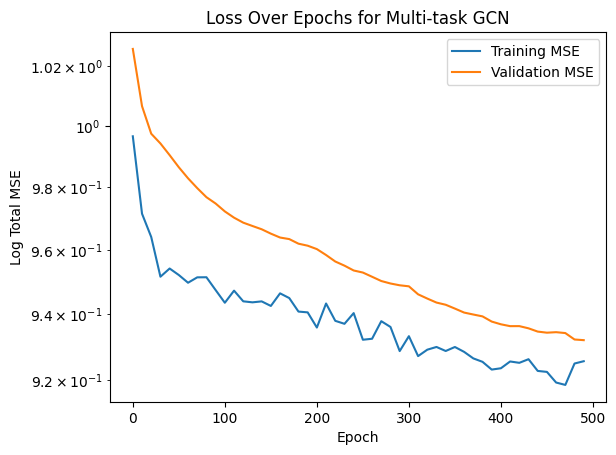

Epoch 000 | Train: 1.0129 | Val: 1.0544 * NEW BEST
Epoch 010 | Train: 0.9918 | Val: 1.0310 * NEW BEST
Epoch 020 | Train: 0.9766 | Val: 1.0146 * NEW BEST
Epoch 030 | Train: 0.9678 | Val: 1.0024 * NEW BEST
Epoch 040 | Train: 0.9584 | Val: 0.9941 * NEW BEST
Epoch 050 | Train: 0.9529 | Val: 0.9896 * NEW BEST
Epoch 060 | Train: 0.9481 | Val: 0.9866 * NEW BEST
Epoch 070 | Train: 0.9474 | Val: 0.9834 * NEW BEST
Epoch 080 | Train: 0.9456 | Val: 0.9784 * NEW BEST
Epoch 090 | Train: 0.9439 | Val: 0.9741 * NEW BEST
Epoch 100 | Train: 0.9395 | Val: 0.9721 * NEW BEST
Epoch 110 | Train: 0.9416 | Val: 0.9680 * NEW BEST
Epoch 120 | Train: 0.9348 | Val: 0.9659 * NEW BEST
Epoch 130 | Train: 0.9357 | Val: 0.9637 * NEW BEST
Epoch 140 | Train: 0.9329 | Val: 0.9609 * NEW BEST
Epoch 150 | Train: 0.9332 | Val: 0.9595 * NEW BEST
Epoch 160 | Train: 0.9279 | Val: 0.9577 * NEW BEST
Epoch 170 | Train: 0.9349 | Val: 0.9561 * NEW BEST
Epoch 180 | Train: 0.9262 | Val: 0.9530 * NEW BEST
Epoch 190 | Train: 0.9250 | Val

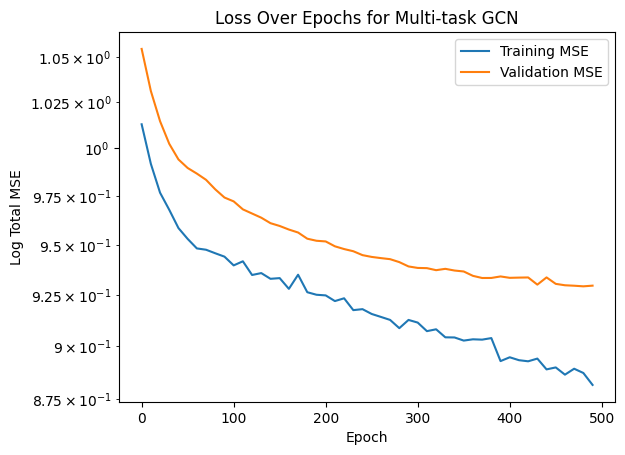

Epoch 000 | Train: 1.0167 | Val: 1.0235 * NEW BEST
Epoch 010 | Train: 0.9851 | Val: 1.0139 * NEW BEST
Epoch 020 | Train: 0.9679 | Val: 1.0158
Epoch 030 | Train: 0.9642 | Val: 1.0137 * NEW BEST
Epoch 040 | Train: 0.9567 | Val: 1.0074 * NEW BEST
Epoch 050 | Train: 0.9590 | Val: 1.0025 * NEW BEST
Epoch 060 | Train: 0.9539 | Val: 0.9993 * NEW BEST
Epoch 070 | Train: 0.9529 | Val: 0.9974 * NEW BEST
Epoch 080 | Train: 0.9537 | Val: 0.9948 * NEW BEST
Epoch 090 | Train: 0.9552 | Val: 0.9921 * NEW BEST
Epoch 100 | Train: 0.9512 | Val: 0.9893 * NEW BEST
Epoch 110 | Train: 0.9518 | Val: 0.9877 * NEW BEST
Epoch 120 | Train: 0.9463 | Val: 0.9853 * NEW BEST
Epoch 130 | Train: 0.9480 | Val: 0.9826 * NEW BEST
Epoch 140 | Train: 0.9437 | Val: 0.9809 * NEW BEST
Epoch 150 | Train: 0.9417 | Val: 0.9790 * NEW BEST
Epoch 160 | Train: 0.9410 | Val: 0.9777 * NEW BEST
Epoch 170 | Train: 0.9459 | Val: 0.9759 * NEW BEST
Epoch 180 | Train: 0.9372 | Val: 0.9738 * NEW BEST
Epoch 190 | Train: 0.9366 | Val: 0.9729 * 

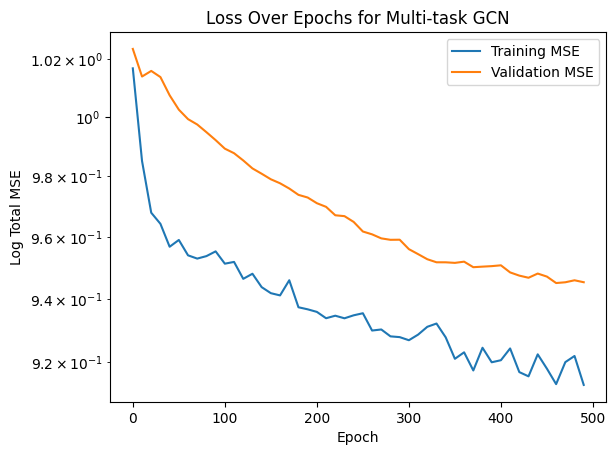

Epoch 000 | Train: 1.0092 | Val: 1.0233 * NEW BEST
Epoch 010 | Train: 0.9816 | Val: 1.0091 * NEW BEST
Epoch 020 | Train: 0.9764 | Val: 1.0028 * NEW BEST
Epoch 030 | Train: 0.9702 | Val: 0.9985 * NEW BEST
Epoch 040 | Train: 0.9614 | Val: 0.9948 * NEW BEST
Epoch 050 | Train: 0.9621 | Val: 0.9924 * NEW BEST
Epoch 060 | Train: 0.9613 | Val: 0.9912 * NEW BEST
Epoch 070 | Train: 0.9586 | Val: 0.9887 * NEW BEST
Epoch 080 | Train: 0.9573 | Val: 0.9863 * NEW BEST
Epoch 090 | Train: 0.9556 | Val: 0.9849 * NEW BEST
Epoch 100 | Train: 0.9494 | Val: 0.9830 * NEW BEST
Epoch 110 | Train: 0.9557 | Val: 0.9809 * NEW BEST
Epoch 120 | Train: 0.9525 | Val: 0.9779 * NEW BEST
Epoch 130 | Train: 0.9472 | Val: 0.9752 * NEW BEST
Epoch 140 | Train: 0.9451 | Val: 0.9746 * NEW BEST
Epoch 150 | Train: 0.9454 | Val: 0.9739 * NEW BEST
Epoch 160 | Train: 0.9443 | Val: 0.9716 * NEW BEST
Epoch 170 | Train: 0.9451 | Val: 0.9699 * NEW BEST
Epoch 180 | Train: 0.9447 | Val: 0.9681 * NEW BEST
Epoch 190 | Train: 0.9416 | Val

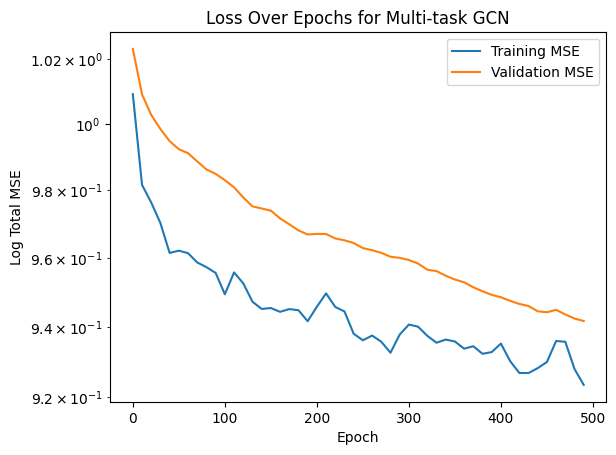

Epoch 000 | Train: 1.0505 | Val: 1.0229 * NEW BEST
Epoch 010 | Train: 1.0012 | Val: 1.0088 * NEW BEST
Epoch 020 | Train: 0.9884 | Val: 1.0062 * NEW BEST
Epoch 030 | Train: 0.9835 | Val: 1.0042 * NEW BEST
Epoch 040 | Train: 0.9794 | Val: 1.0009 * NEW BEST
Epoch 050 | Train: 0.9748 | Val: 0.9986 * NEW BEST
Epoch 060 | Train: 0.9699 | Val: 0.9960 * NEW BEST
Epoch 070 | Train: 0.9684 | Val: 0.9943 * NEW BEST
Epoch 080 | Train: 0.9689 | Val: 0.9929 * NEW BEST
Epoch 090 | Train: 0.9608 | Val: 0.9910 * NEW BEST
Epoch 100 | Train: 0.9639 | Val: 0.9892 * NEW BEST
Epoch 110 | Train: 0.9629 | Val: 0.9881 * NEW BEST
Epoch 120 | Train: 0.9581 | Val: 0.9873 * NEW BEST
Epoch 130 | Train: 0.9611 | Val: 0.9859 * NEW BEST
Epoch 140 | Train: 0.9593 | Val: 0.9846 * NEW BEST
Epoch 150 | Train: 0.9571 | Val: 0.9835 * NEW BEST
Epoch 160 | Train: 0.9553 | Val: 0.9824 * NEW BEST
Epoch 170 | Train: 0.9561 | Val: 0.9809 * NEW BEST
Epoch 180 | Train: 0.9563 | Val: 0.9804 * NEW BEST
Epoch 190 | Train: 0.9558 | Val

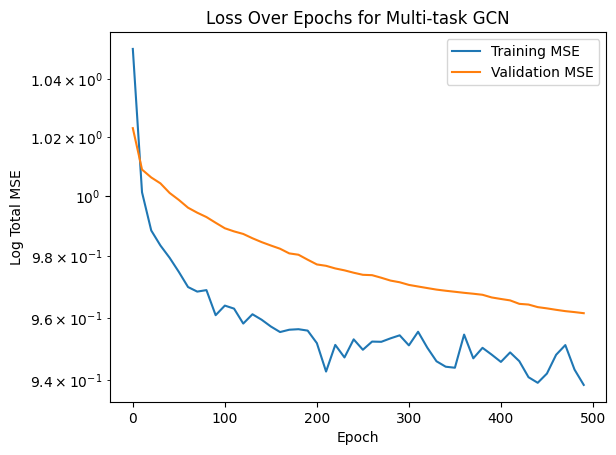

Epoch 000 | Train: 1.0026 | Val: 1.0436 * NEW BEST
Epoch 010 | Train: 0.9691 | Val: 1.0068 * NEW BEST
Epoch 020 | Train: 0.9544 | Val: 0.9959 * NEW BEST
Epoch 030 | Train: 0.9504 | Val: 0.9896 * NEW BEST
Epoch 040 | Train: 0.9463 | Val: 0.9827 * NEW BEST
Epoch 050 | Train: 0.9455 | Val: 0.9771 * NEW BEST
Epoch 060 | Train: 0.9405 | Val: 0.9741 * NEW BEST
Epoch 070 | Train: 0.9414 | Val: 0.9709 * NEW BEST
Epoch 080 | Train: 0.9360 | Val: 0.9677 * NEW BEST
Epoch 090 | Train: 0.9333 | Val: 0.9639 * NEW BEST
Epoch 100 | Train: 0.9311 | Val: 0.9609 * NEW BEST
Epoch 110 | Train: 0.9269 | Val: 0.9582 * NEW BEST
Epoch 120 | Train: 0.9265 | Val: 0.9572 * NEW BEST
Epoch 130 | Train: 0.9241 | Val: 0.9522 * NEW BEST
Epoch 140 | Train: 0.9228 | Val: 0.9510 * NEW BEST
Epoch 150 | Train: 0.9193 | Val: 0.9490 * NEW BEST
Epoch 160 | Train: 0.9197 | Val: 0.9470 * NEW BEST
Epoch 170 | Train: 0.9157 | Val: 0.9482
Epoch 180 | Train: 0.9130 | Val: 0.9463 * NEW BEST
Epoch 190 | Train: 0.9091 | Val: 0.9462 * 

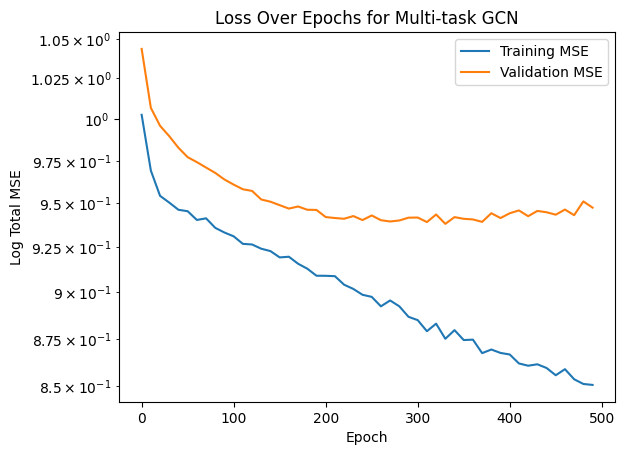

Epoch 000 | Train: 0.9877 | Val: 1.0096 * NEW BEST
Epoch 010 | Train: 0.9642 | Val: 1.0020 * NEW BEST
Epoch 020 | Train: 0.9567 | Val: 0.9969 * NEW BEST
Epoch 030 | Train: 0.9547 | Val: 0.9896 * NEW BEST
Epoch 040 | Train: 0.9464 | Val: 0.9835 * NEW BEST
Epoch 050 | Train: 0.9433 | Val: 0.9775 * NEW BEST
Epoch 060 | Train: 0.9445 | Val: 0.9723 * NEW BEST
Epoch 070 | Train: 0.9347 | Val: 0.9683 * NEW BEST
Epoch 080 | Train: 0.9390 | Val: 0.9639 * NEW BEST
Epoch 090 | Train: 0.9369 | Val: 0.9602 * NEW BEST
Epoch 100 | Train: 0.9339 | Val: 0.9565 * NEW BEST
Epoch 110 | Train: 0.9332 | Val: 0.9524 * NEW BEST
Epoch 120 | Train: 0.9292 | Val: 0.9493 * NEW BEST
Epoch 130 | Train: 0.9277 | Val: 0.9491 * NEW BEST
Epoch 140 | Train: 0.9199 | Val: 0.9462 * NEW BEST
Epoch 150 | Train: 0.9263 | Val: 0.9432 * NEW BEST
Epoch 160 | Train: 0.9209 | Val: 0.9398 * NEW BEST
Epoch 170 | Train: 0.9213 | Val: 0.9390 * NEW BEST
Epoch 180 | Train: 0.9212 | Val: 0.9373 * NEW BEST
Epoch 190 | Train: 0.9154 | Val

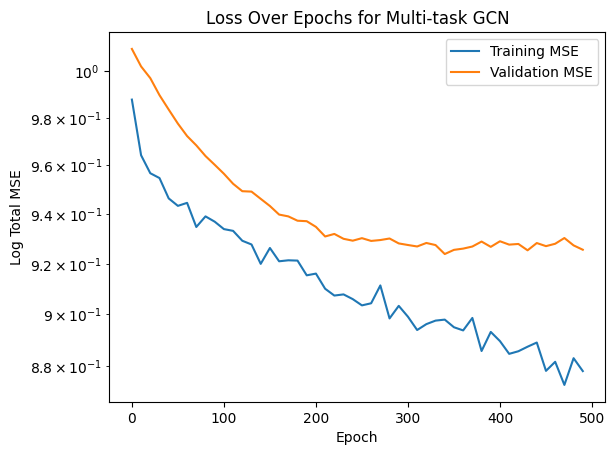

Epoch 000 | Train: 0.9928 | Val: 1.0135 * NEW BEST
Epoch 010 | Train: 0.9657 | Val: 1.0044 * NEW BEST
Epoch 020 | Train: 0.9591 | Val: 0.9975 * NEW BEST
Epoch 030 | Train: 0.9615 | Val: 0.9920 * NEW BEST
Epoch 040 | Train: 0.9541 | Val: 0.9872 * NEW BEST
Epoch 050 | Train: 0.9533 | Val: 0.9833 * NEW BEST
Epoch 060 | Train: 0.9468 | Val: 0.9783 * NEW BEST
Epoch 070 | Train: 0.9493 | Val: 0.9751 * NEW BEST
Epoch 080 | Train: 0.9425 | Val: 0.9720 * NEW BEST
Epoch 090 | Train: 0.9456 | Val: 0.9691 * NEW BEST
Epoch 100 | Train: 0.9376 | Val: 0.9663 * NEW BEST
Epoch 110 | Train: 0.9399 | Val: 0.9623 * NEW BEST
Epoch 120 | Train: 0.9365 | Val: 0.9604 * NEW BEST
Epoch 130 | Train: 0.9407 | Val: 0.9579 * NEW BEST
Epoch 140 | Train: 0.9401 | Val: 0.9566 * NEW BEST
Epoch 150 | Train: 0.9353 | Val: 0.9530 * NEW BEST
Epoch 160 | Train: 0.9355 | Val: 0.9501 * NEW BEST
Epoch 170 | Train: 0.9309 | Val: 0.9498 * NEW BEST
Epoch 180 | Train: 0.9333 | Val: 0.9482 * NEW BEST
Epoch 190 | Train: 0.9264 | Val

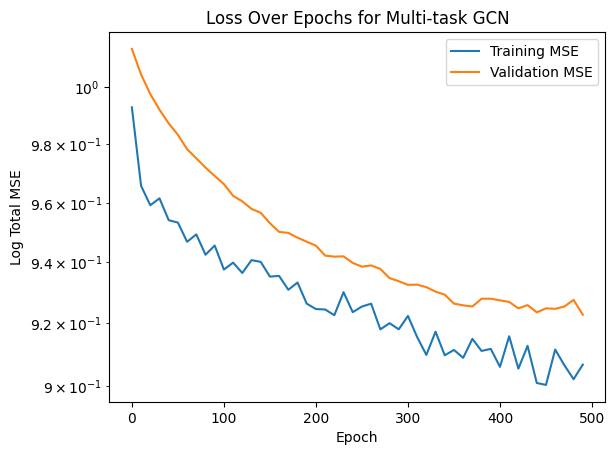

Epoch 000 | Train: 0.9994 | Val: 1.0150 * NEW BEST
Epoch 010 | Train: 0.9753 | Val: 1.0055 * NEW BEST
Epoch 020 | Train: 0.9624 | Val: 0.9994 * NEW BEST
Epoch 030 | Train: 0.9678 | Val: 0.9952 * NEW BEST
Epoch 040 | Train: 0.9566 | Val: 0.9928 * NEW BEST
Epoch 050 | Train: 0.9616 | Val: 0.9894 * NEW BEST
Epoch 060 | Train: 0.9520 | Val: 0.9863 * NEW BEST
Epoch 070 | Train: 0.9556 | Val: 0.9841 * NEW BEST
Epoch 080 | Train: 0.9497 | Val: 0.9809 * NEW BEST
Epoch 090 | Train: 0.9527 | Val: 0.9788 * NEW BEST
Epoch 100 | Train: 0.9540 | Val: 0.9770 * NEW BEST
Epoch 110 | Train: 0.9499 | Val: 0.9750 * NEW BEST
Epoch 120 | Train: 0.9466 | Val: 0.9727 * NEW BEST
Epoch 130 | Train: 0.9436 | Val: 0.9718 * NEW BEST
Epoch 140 | Train: 0.9549 | Val: 0.9702 * NEW BEST
Epoch 150 | Train: 0.9451 | Val: 0.9680 * NEW BEST
Epoch 160 | Train: 0.9484 | Val: 0.9656 * NEW BEST
Epoch 170 | Train: 0.9458 | Val: 0.9649 * NEW BEST
Epoch 180 | Train: 0.9446 | Val: 0.9628 * NEW BEST
Epoch 190 | Train: 0.9408 | Val

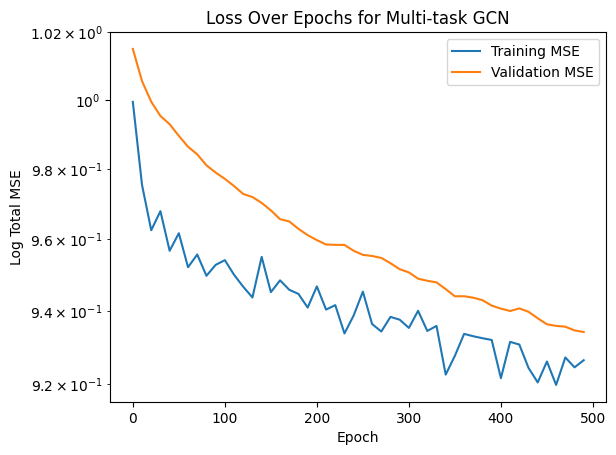

Epoch 000 | Train: 0.9884 | Val: 1.0106 * NEW BEST
Epoch 010 | Train: 0.9552 | Val: 0.9951 * NEW BEST
Epoch 020 | Train: 0.9469 | Val: 0.9933 * NEW BEST
Epoch 030 | Train: 0.9409 | Val: 0.9794 * NEW BEST
Epoch 040 | Train: 0.9364 | Val: 0.9708 * NEW BEST
Epoch 050 | Train: 0.9318 | Val: 0.9659 * NEW BEST
Epoch 060 | Train: 0.9283 | Val: 0.9596 * NEW BEST
Epoch 070 | Train: 0.9232 | Val: 0.9552 * NEW BEST
Epoch 080 | Train: 0.9158 | Val: 0.9541 * NEW BEST
Epoch 090 | Train: 0.9108 | Val: 0.9498 * NEW BEST
Epoch 100 | Train: 0.9061 | Val: 0.9464 * NEW BEST
Epoch 110 | Train: 0.9024 | Val: 0.9458 * NEW BEST
Epoch 120 | Train: 0.8985 | Val: 0.9448 * NEW BEST
Epoch 130 | Train: 0.8915 | Val: 0.9417 * NEW BEST
Epoch 140 | Train: 0.8866 | Val: 0.9416 * NEW BEST
Epoch 150 | Train: 0.8845 | Val: 0.9394 * NEW BEST
Epoch 160 | Train: 0.8804 | Val: 0.9403
Epoch 170 | Train: 0.8764 | Val: 0.9426
Epoch 180 | Train: 0.8735 | Val: 0.9409
Epoch 190 | Train: 0.8671 | Val: 0.9414
Epoch 200 | Train: 0.860

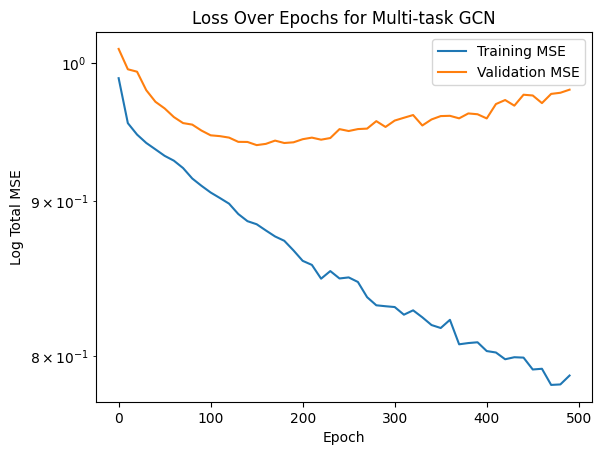

Epoch 000 | Train: 0.9912 | Val: 1.0144 * NEW BEST
Epoch 010 | Train: 0.9615 | Val: 0.9987 * NEW BEST
Epoch 020 | Train: 0.9517 | Val: 0.9953 * NEW BEST
Epoch 030 | Train: 0.9450 | Val: 0.9821 * NEW BEST
Epoch 040 | Train: 0.9405 | Val: 0.9729 * NEW BEST
Epoch 050 | Train: 0.9373 | Val: 0.9690 * NEW BEST
Epoch 060 | Train: 0.9349 | Val: 0.9614 * NEW BEST
Epoch 070 | Train: 0.9318 | Val: 0.9576 * NEW BEST
Epoch 080 | Train: 0.9262 | Val: 0.9515 * NEW BEST
Epoch 090 | Train: 0.9232 | Val: 0.9492 * NEW BEST
Epoch 100 | Train: 0.9218 | Val: 0.9452 * NEW BEST
Epoch 110 | Train: 0.9179 | Val: 0.9447 * NEW BEST
Epoch 120 | Train: 0.9142 | Val: 0.9398 * NEW BEST
Epoch 130 | Train: 0.9135 | Val: 0.9397 * NEW BEST
Epoch 140 | Train: 0.9090 | Val: 0.9367 * NEW BEST
Epoch 150 | Train: 0.9084 | Val: 0.9333 * NEW BEST
Epoch 160 | Train: 0.9015 | Val: 0.9379
Epoch 170 | Train: 0.9001 | Val: 0.9318 * NEW BEST
Epoch 180 | Train: 0.9045 | Val: 0.9371
Epoch 190 | Train: 0.8942 | Val: 0.9331
Epoch 200 | T

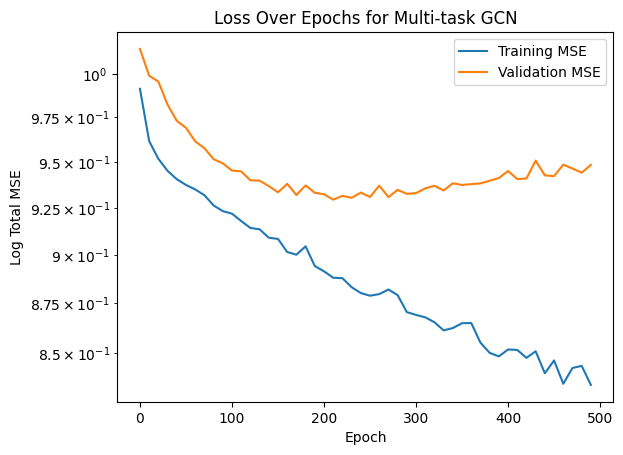

Epoch 000 | Train: 0.9902 | Val: 1.0100 * NEW BEST
Epoch 010 | Train: 0.9558 | Val: 0.9966 * NEW BEST
Epoch 020 | Train: 0.9541 | Val: 0.9944 * NEW BEST
Epoch 030 | Train: 0.9474 | Val: 0.9834 * NEW BEST
Epoch 040 | Train: 0.9411 | Val: 0.9757 * NEW BEST
Epoch 050 | Train: 0.9417 | Val: 0.9718 * NEW BEST
Epoch 060 | Train: 0.9373 | Val: 0.9670 * NEW BEST
Epoch 070 | Train: 0.9382 | Val: 0.9613 * NEW BEST
Epoch 080 | Train: 0.9351 | Val: 0.9598 * NEW BEST
Epoch 090 | Train: 0.9335 | Val: 0.9565 * NEW BEST
Epoch 100 | Train: 0.9247 | Val: 0.9519 * NEW BEST
Epoch 110 | Train: 0.9316 | Val: 0.9489 * NEW BEST
Epoch 120 | Train: 0.9261 | Val: 0.9466 * NEW BEST
Epoch 130 | Train: 0.9241 | Val: 0.9485
Epoch 140 | Train: 0.9192 | Val: 0.9436 * NEW BEST
Epoch 150 | Train: 0.9224 | Val: 0.9414 * NEW BEST
Epoch 160 | Train: 0.9227 | Val: 0.9389 * NEW BEST
Epoch 170 | Train: 0.9167 | Val: 0.9384 * NEW BEST
Epoch 180 | Train: 0.9149 | Val: 0.9341 * NEW BEST
Epoch 190 | Train: 0.9144 | Val: 0.9378
Ep

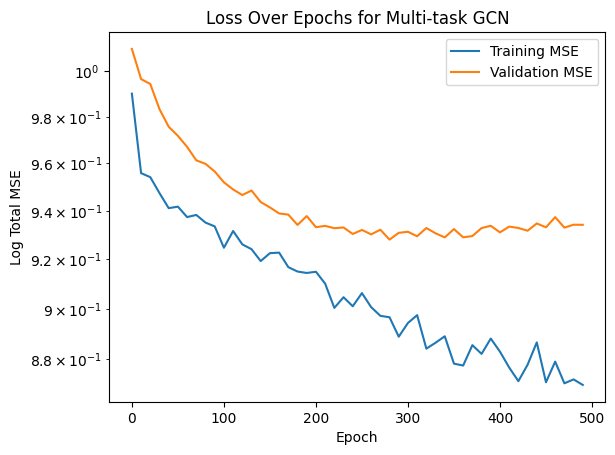

Epoch 000 | Train: 1.0060 | Val: 1.0108 * NEW BEST
Epoch 010 | Train: 0.9690 | Val: 1.0097 * NEW BEST
Epoch 020 | Train: 0.9591 | Val: 0.9955 * NEW BEST
Epoch 030 | Train: 0.9480 | Val: 0.9868 * NEW BEST
Epoch 040 | Train: 0.9470 | Val: 0.9810 * NEW BEST
Epoch 050 | Train: 0.9531 | Val: 0.9768 * NEW BEST
Epoch 060 | Train: 0.9479 | Val: 0.9738 * NEW BEST
Epoch 070 | Train: 0.9446 | Val: 0.9700 * NEW BEST
Epoch 080 | Train: 0.9408 | Val: 0.9662 * NEW BEST
Epoch 090 | Train: 0.9425 | Val: 0.9637 * NEW BEST
Epoch 100 | Train: 0.9407 | Val: 0.9619 * NEW BEST
Epoch 110 | Train: 0.9358 | Val: 0.9579 * NEW BEST
Epoch 120 | Train: 0.9346 | Val: 0.9561 * NEW BEST
Epoch 130 | Train: 0.9334 | Val: 0.9532 * NEW BEST
Epoch 140 | Train: 0.9382 | Val: 0.9494 * NEW BEST
Epoch 150 | Train: 0.9329 | Val: 0.9477 * NEW BEST
Epoch 160 | Train: 0.9325 | Val: 0.9447 * NEW BEST
Epoch 170 | Train: 0.9303 | Val: 0.9426 * NEW BEST
Epoch 180 | Train: 0.9251 | Val: 0.9427
Epoch 190 | Train: 0.9210 | Val: 0.9403 * 

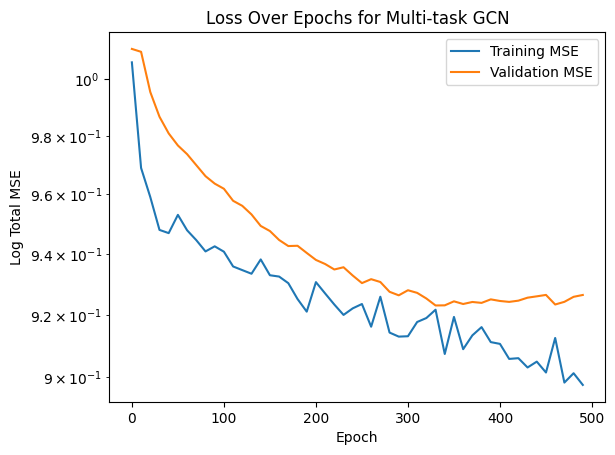

Epoch 000 | Train: 1.0056 | Val: 1.0363 * NEW BEST
Epoch 010 | Train: 1.0047 | Val: 1.0346 * NEW BEST
Epoch 020 | Train: 1.0034 | Val: 1.0329 * NEW BEST
Epoch 030 | Train: 1.0022 | Val: 1.0313 * NEW BEST
Epoch 040 | Train: 1.0010 | Val: 1.0297 * NEW BEST
Epoch 050 | Train: 0.9995 | Val: 1.0282 * NEW BEST
Epoch 060 | Train: 0.9964 | Val: 1.0268 * NEW BEST
Epoch 070 | Train: 0.9954 | Val: 1.0254 * NEW BEST
Epoch 080 | Train: 0.9949 | Val: 1.0241 * NEW BEST
Epoch 090 | Train: 0.9933 | Val: 1.0228 * NEW BEST
Epoch 100 | Train: 0.9924 | Val: 1.0216 * NEW BEST
Epoch 110 | Train: 0.9909 | Val: 1.0204 * NEW BEST
Epoch 120 | Train: 0.9910 | Val: 1.0193 * NEW BEST
Epoch 130 | Train: 0.9888 | Val: 1.0182 * NEW BEST
Epoch 140 | Train: 0.9882 | Val: 1.0171 * NEW BEST
Epoch 150 | Train: 0.9879 | Val: 1.0161 * NEW BEST
Epoch 160 | Train: 0.9871 | Val: 1.0151 * NEW BEST
Epoch 170 | Train: 0.9859 | Val: 1.0142 * NEW BEST
Epoch 180 | Train: 0.9848 | Val: 1.0132 * NEW BEST
Epoch 190 | Train: 0.9839 | Val

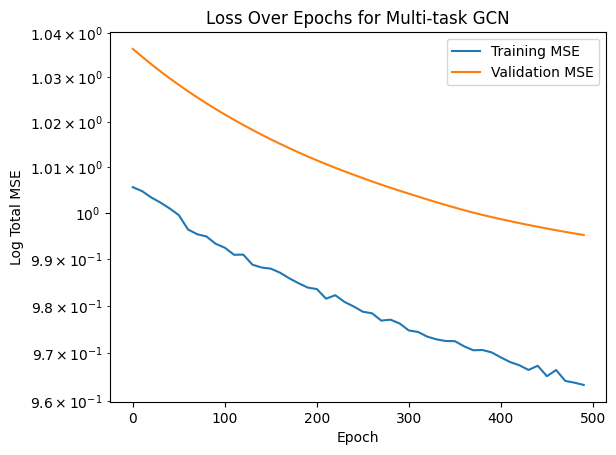

Epoch 000 | Train: 1.0052 | Val: 1.0304 * NEW BEST
Epoch 010 | Train: 1.0012 | Val: 1.0287 * NEW BEST
Epoch 020 | Train: 1.0024 | Val: 1.0271 * NEW BEST
Epoch 030 | Train: 0.9965 | Val: 1.0256 * NEW BEST
Epoch 040 | Train: 1.0002 | Val: 1.0241 * NEW BEST
Epoch 050 | Train: 0.9956 | Val: 1.0227 * NEW BEST
Epoch 060 | Train: 1.0007 | Val: 1.0213 * NEW BEST
Epoch 070 | Train: 0.9975 | Val: 1.0201 * NEW BEST
Epoch 080 | Train: 0.9955 | Val: 1.0188 * NEW BEST
Epoch 090 | Train: 0.9924 | Val: 1.0177 * NEW BEST
Epoch 100 | Train: 0.9937 | Val: 1.0166 * NEW BEST
Epoch 110 | Train: 0.9868 | Val: 1.0155 * NEW BEST
Epoch 120 | Train: 0.9877 | Val: 1.0145 * NEW BEST
Epoch 130 | Train: 0.9881 | Val: 1.0135 * NEW BEST
Epoch 140 | Train: 0.9852 | Val: 1.0126 * NEW BEST
Epoch 150 | Train: 0.9861 | Val: 1.0116 * NEW BEST
Epoch 160 | Train: 0.9864 | Val: 1.0107 * NEW BEST
Epoch 170 | Train: 0.9855 | Val: 1.0099 * NEW BEST
Epoch 180 | Train: 0.9878 | Val: 1.0090 * NEW BEST
Epoch 190 | Train: 0.9838 | Val

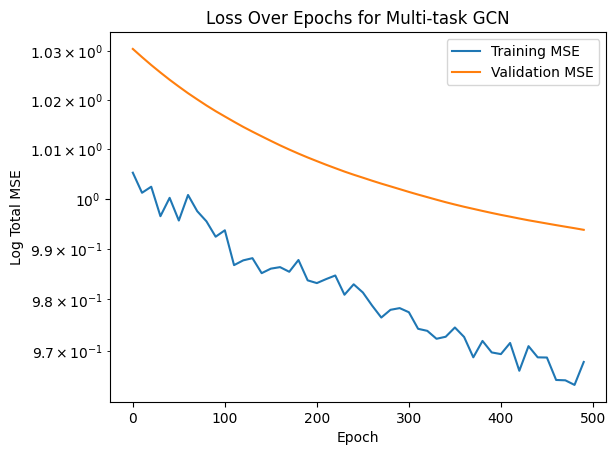

Epoch 000 | Train: 1.0421 | Val: 1.0745 * NEW BEST
Epoch 010 | Train: 1.0452 | Val: 1.0715 * NEW BEST
Epoch 020 | Train: 1.0405 | Val: 1.0688 * NEW BEST
Epoch 030 | Train: 1.0389 | Val: 1.0662 * NEW BEST
Epoch 040 | Train: 1.0351 | Val: 1.0637 * NEW BEST
Epoch 050 | Train: 1.0320 | Val: 1.0613 * NEW BEST
Epoch 060 | Train: 1.0242 | Val: 1.0591 * NEW BEST
Epoch 070 | Train: 1.0327 | Val: 1.0571 * NEW BEST
Epoch 080 | Train: 1.0214 | Val: 1.0551 * NEW BEST
Epoch 090 | Train: 1.0218 | Val: 1.0532 * NEW BEST
Epoch 100 | Train: 1.0243 | Val: 1.0514 * NEW BEST
Epoch 110 | Train: 1.0159 | Val: 1.0497 * NEW BEST
Epoch 120 | Train: 1.0159 | Val: 1.0481 * NEW BEST
Epoch 130 | Train: 1.0158 | Val: 1.0466 * NEW BEST
Epoch 140 | Train: 1.0097 | Val: 1.0451 * NEW BEST
Epoch 150 | Train: 1.0157 | Val: 1.0436 * NEW BEST
Epoch 160 | Train: 1.0124 | Val: 1.0423 * NEW BEST
Epoch 170 | Train: 1.0084 | Val: 1.0410 * NEW BEST
Epoch 180 | Train: 1.0089 | Val: 1.0398 * NEW BEST
Epoch 190 | Train: 1.0084 | Val

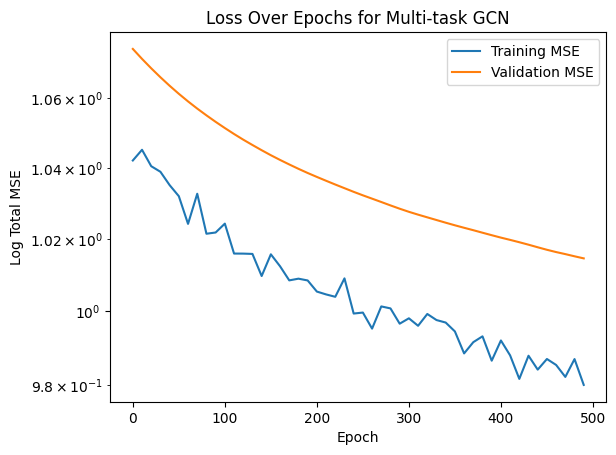

Epoch 000 | Train: 1.0148 | Val: 1.0292 * NEW BEST
Epoch 010 | Train: 1.0166 | Val: 1.0288 * NEW BEST
Epoch 020 | Train: 1.0091 | Val: 1.0285 * NEW BEST
Epoch 030 | Train: 1.0089 | Val: 1.0281 * NEW BEST
Epoch 040 | Train: 1.0109 | Val: 1.0278 * NEW BEST
Epoch 050 | Train: 1.0142 | Val: 1.0275 * NEW BEST
Epoch 060 | Train: 1.0063 | Val: 1.0271 * NEW BEST
Epoch 070 | Train: 1.0137 | Val: 1.0268 * NEW BEST
Epoch 080 | Train: 1.0024 | Val: 1.0265 * NEW BEST
Epoch 090 | Train: 1.0062 | Val: 1.0261 * NEW BEST
Epoch 100 | Train: 1.0071 | Val: 1.0257 * NEW BEST
Epoch 110 | Train: 1.0090 | Val: 1.0253 * NEW BEST
Epoch 120 | Train: 1.0019 | Val: 1.0250 * NEW BEST
Epoch 130 | Train: 1.0010 | Val: 1.0246 * NEW BEST
Epoch 140 | Train: 0.9984 | Val: 1.0242 * NEW BEST
Epoch 150 | Train: 1.0026 | Val: 1.0238 * NEW BEST
Epoch 160 | Train: 0.9982 | Val: 1.0234 * NEW BEST
Epoch 170 | Train: 0.9989 | Val: 1.0230 * NEW BEST
Epoch 180 | Train: 1.0000 | Val: 1.0226 * NEW BEST
Epoch 190 | Train: 0.9982 | Val

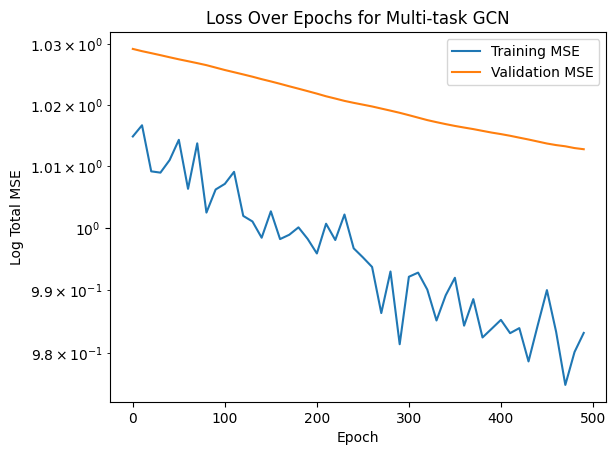

Epoch 000 | Train: 0.9917 | Val: 1.0163 * NEW BEST
Epoch 010 | Train: 0.9895 | Val: 1.0148 * NEW BEST
Epoch 020 | Train: 0.9868 | Val: 1.0135 * NEW BEST
Epoch 030 | Train: 0.9854 | Val: 1.0123 * NEW BEST
Epoch 040 | Train: 0.9838 | Val: 1.0112 * NEW BEST
Epoch 050 | Train: 0.9828 | Val: 1.0101 * NEW BEST
Epoch 060 | Train: 0.9810 | Val: 1.0091 * NEW BEST
Epoch 070 | Train: 0.9794 | Val: 1.0082 * NEW BEST
Epoch 080 | Train: 0.9764 | Val: 1.0073 * NEW BEST
Epoch 090 | Train: 0.9768 | Val: 1.0065 * NEW BEST
Epoch 100 | Train: 0.9745 | Val: 1.0057 * NEW BEST
Epoch 110 | Train: 0.9743 | Val: 1.0050 * NEW BEST
Epoch 120 | Train: 0.9727 | Val: 1.0043 * NEW BEST
Epoch 130 | Train: 0.9711 | Val: 1.0036 * NEW BEST
Epoch 140 | Train: 0.9717 | Val: 1.0030 * NEW BEST
Epoch 150 | Train: 0.9687 | Val: 1.0025 * NEW BEST
Epoch 160 | Train: 0.9696 | Val: 1.0019 * NEW BEST
Epoch 170 | Train: 0.9679 | Val: 1.0014 * NEW BEST
Epoch 180 | Train: 0.9665 | Val: 1.0009 * NEW BEST
Epoch 190 | Train: 0.9657 | Val

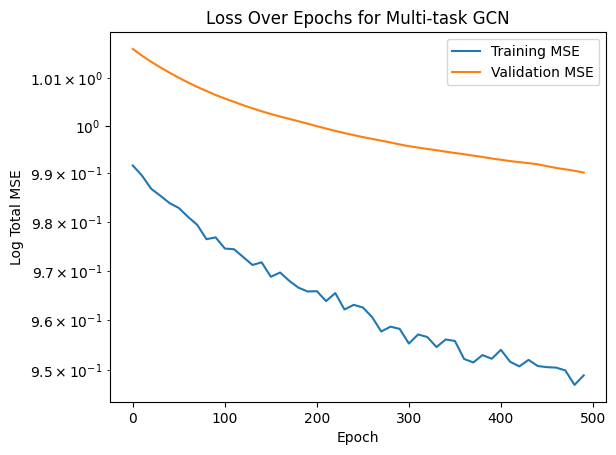

Epoch 000 | Train: 1.0014 | Val: 1.0021 * NEW BEST
Epoch 010 | Train: 0.9980 | Val: 1.0005 * NEW BEST
Epoch 020 | Train: 0.9929 | Val: 0.9990 * NEW BEST
Epoch 030 | Train: 0.9950 | Val: 0.9978 * NEW BEST
Epoch 040 | Train: 0.9891 | Val: 0.9966 * NEW BEST
Epoch 050 | Train: 0.9895 | Val: 0.9955 * NEW BEST
Epoch 060 | Train: 0.9871 | Val: 0.9945 * NEW BEST
Epoch 070 | Train: 0.9832 | Val: 0.9935 * NEW BEST
Epoch 080 | Train: 0.9830 | Val: 0.9926 * NEW BEST
Epoch 090 | Train: 0.9794 | Val: 0.9917 * NEW BEST
Epoch 100 | Train: 0.9779 | Val: 0.9910 * NEW BEST
Epoch 110 | Train: 0.9768 | Val: 0.9902 * NEW BEST
Epoch 120 | Train: 0.9779 | Val: 0.9895 * NEW BEST
Epoch 130 | Train: 0.9743 | Val: 0.9888 * NEW BEST
Epoch 140 | Train: 0.9733 | Val: 0.9882 * NEW BEST
Epoch 150 | Train: 0.9705 | Val: 0.9876 * NEW BEST
Epoch 160 | Train: 0.9706 | Val: 0.9871 * NEW BEST
Epoch 170 | Train: 0.9676 | Val: 0.9866 * NEW BEST
Epoch 180 | Train: 0.9678 | Val: 0.9861 * NEW BEST
Epoch 190 | Train: 0.9681 | Val

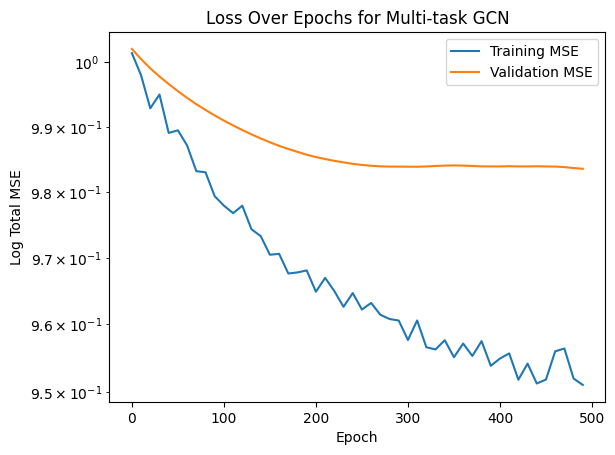

Epoch 000 | Train: 0.9948 | Val: 1.0217 * NEW BEST
Epoch 010 | Train: 0.9944 | Val: 1.0206 * NEW BEST
Epoch 020 | Train: 0.9887 | Val: 1.0195 * NEW BEST
Epoch 030 | Train: 0.9925 | Val: 1.0185 * NEW BEST
Epoch 040 | Train: 0.9868 | Val: 1.0175 * NEW BEST
Epoch 050 | Train: 0.9885 | Val: 1.0165 * NEW BEST
Epoch 060 | Train: 0.9841 | Val: 1.0156 * NEW BEST
Epoch 070 | Train: 0.9868 | Val: 1.0146 * NEW BEST
Epoch 080 | Train: 0.9837 | Val: 1.0137 * NEW BEST
Epoch 090 | Train: 0.9848 | Val: 1.0128 * NEW BEST
Epoch 100 | Train: 0.9823 | Val: 1.0119 * NEW BEST
Epoch 110 | Train: 0.9848 | Val: 1.0111 * NEW BEST
Epoch 120 | Train: 0.9779 | Val: 1.0103 * NEW BEST
Epoch 130 | Train: 0.9765 | Val: 1.0095 * NEW BEST
Epoch 140 | Train: 0.9733 | Val: 1.0087 * NEW BEST
Epoch 150 | Train: 0.9775 | Val: 1.0081 * NEW BEST
Epoch 160 | Train: 0.9757 | Val: 1.0074 * NEW BEST
Epoch 170 | Train: 0.9760 | Val: 1.0068 * NEW BEST
Epoch 180 | Train: 0.9749 | Val: 1.0062 * NEW BEST
Epoch 190 | Train: 0.9756 | Val

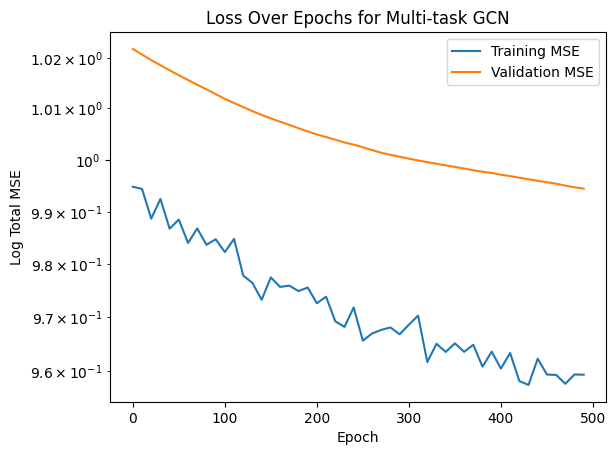

Epoch 000 | Train: 1.0031 | Val: 1.0002 * NEW BEST
Epoch 010 | Train: 0.9979 | Val: 0.9993 * NEW BEST
Epoch 020 | Train: 1.0047 | Val: 0.9985 * NEW BEST
Epoch 030 | Train: 0.9973 | Val: 0.9979 * NEW BEST
Epoch 040 | Train: 0.9952 | Val: 0.9973 * NEW BEST
Epoch 050 | Train: 0.9893 | Val: 0.9969 * NEW BEST
Epoch 060 | Train: 0.9857 | Val: 0.9965 * NEW BEST
Epoch 070 | Train: 0.9872 | Val: 0.9963 * NEW BEST
Epoch 080 | Train: 0.9872 | Val: 0.9960 * NEW BEST
Epoch 090 | Train: 0.9917 | Val: 0.9957 * NEW BEST
Epoch 100 | Train: 0.9857 | Val: 0.9955 * NEW BEST
Epoch 110 | Train: 0.9874 | Val: 0.9953 * NEW BEST
Epoch 120 | Train: 0.9789 | Val: 0.9951 * NEW BEST
Epoch 130 | Train: 0.9797 | Val: 0.9949 * NEW BEST
Epoch 140 | Train: 0.9814 | Val: 0.9947 * NEW BEST
Epoch 150 | Train: 0.9789 | Val: 0.9945 * NEW BEST
Epoch 160 | Train: 0.9825 | Val: 0.9943 * NEW BEST
Epoch 170 | Train: 0.9808 | Val: 0.9941 * NEW BEST
Epoch 180 | Train: 0.9801 | Val: 0.9939 * NEW BEST
Epoch 190 | Train: 0.9781 | Val

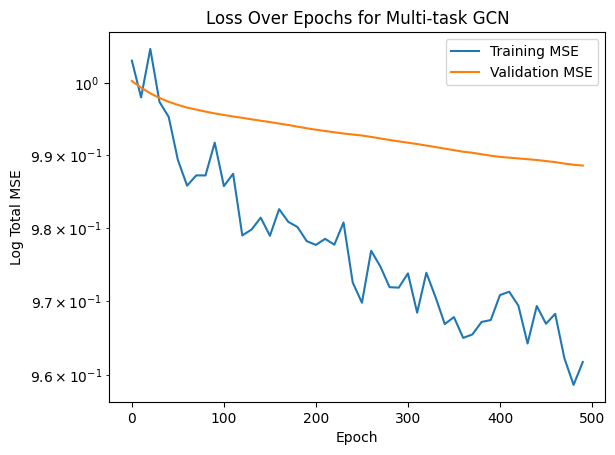

Epoch 000 | Train: 0.9918 | Val: 1.0136 * NEW BEST
Epoch 010 | Train: 0.9878 | Val: 1.0122 * NEW BEST
Epoch 020 | Train: 0.9845 | Val: 1.0110 * NEW BEST
Epoch 030 | Train: 0.9829 | Val: 1.0098 * NEW BEST
Epoch 040 | Train: 0.9797 | Val: 1.0087 * NEW BEST
Epoch 050 | Train: 0.9780 | Val: 1.0075 * NEW BEST
Epoch 060 | Train: 0.9753 | Val: 1.0063 * NEW BEST
Epoch 070 | Train: 0.9740 | Val: 1.0051 * NEW BEST
Epoch 080 | Train: 0.9709 | Val: 1.0039 * NEW BEST
Epoch 090 | Train: 0.9702 | Val: 1.0028 * NEW BEST
Epoch 100 | Train: 0.9670 | Val: 1.0017 * NEW BEST
Epoch 110 | Train: 0.9671 | Val: 1.0007 * NEW BEST
Epoch 120 | Train: 0.9633 | Val: 0.9997 * NEW BEST
Epoch 130 | Train: 0.9638 | Val: 0.9988 * NEW BEST
Epoch 140 | Train: 0.9612 | Val: 0.9980 * NEW BEST
Epoch 150 | Train: 0.9598 | Val: 0.9973 * NEW BEST
Epoch 160 | Train: 0.9590 | Val: 0.9966 * NEW BEST
Epoch 170 | Train: 0.9594 | Val: 0.9960 * NEW BEST
Epoch 180 | Train: 0.9572 | Val: 0.9953 * NEW BEST
Epoch 190 | Train: 0.9564 | Val

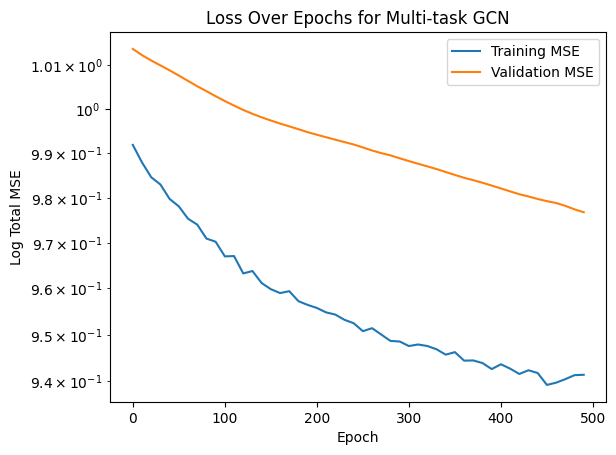

Epoch 000 | Train: 0.9935 | Val: 1.0086 * NEW BEST
Epoch 010 | Train: 0.9912 | Val: 1.0069 * NEW BEST
Epoch 020 | Train: 0.9887 | Val: 1.0053 * NEW BEST
Epoch 030 | Train: 0.9864 | Val: 1.0040 * NEW BEST
Epoch 040 | Train: 0.9810 | Val: 1.0028 * NEW BEST
Epoch 050 | Train: 0.9784 | Val: 1.0017 * NEW BEST
Epoch 060 | Train: 0.9769 | Val: 1.0007 * NEW BEST
Epoch 070 | Train: 0.9750 | Val: 0.9998 * NEW BEST
Epoch 080 | Train: 0.9734 | Val: 0.9990 * NEW BEST
Epoch 090 | Train: 0.9712 | Val: 0.9982 * NEW BEST
Epoch 100 | Train: 0.9709 | Val: 0.9975 * NEW BEST
Epoch 110 | Train: 0.9715 | Val: 0.9969 * NEW BEST
Epoch 120 | Train: 0.9659 | Val: 0.9964 * NEW BEST
Epoch 130 | Train: 0.9662 | Val: 0.9960 * NEW BEST
Epoch 140 | Train: 0.9647 | Val: 0.9956 * NEW BEST
Epoch 150 | Train: 0.9629 | Val: 0.9953 * NEW BEST
Epoch 160 | Train: 0.9623 | Val: 0.9950 * NEW BEST
Epoch 170 | Train: 0.9598 | Val: 0.9948 * NEW BEST
Epoch 180 | Train: 0.9597 | Val: 0.9946 * NEW BEST
Epoch 190 | Train: 0.9605 | Val

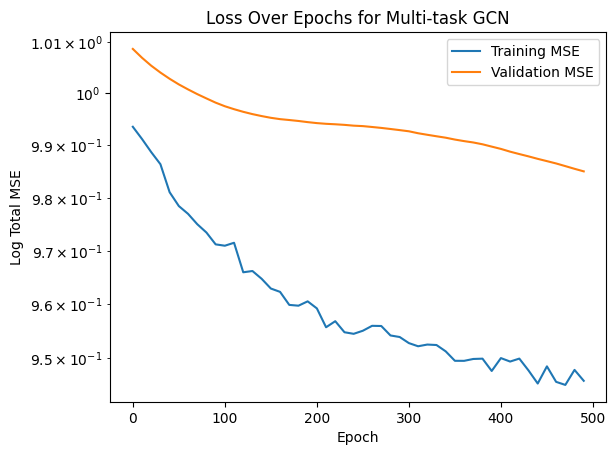

Epoch 000 | Train: 0.9916 | Val: 1.0360 * NEW BEST
Epoch 010 | Train: 0.9872 | Val: 1.0317 * NEW BEST
Epoch 020 | Train: 0.9873 | Val: 1.0280 * NEW BEST
Epoch 030 | Train: 0.9842 | Val: 1.0249 * NEW BEST
Epoch 040 | Train: 0.9829 | Val: 1.0221 * NEW BEST
Epoch 050 | Train: 0.9772 | Val: 1.0197 * NEW BEST
Epoch 060 | Train: 0.9771 | Val: 1.0175 * NEW BEST
Epoch 070 | Train: 0.9746 | Val: 1.0155 * NEW BEST
Epoch 080 | Train: 0.9735 | Val: 1.0138 * NEW BEST
Epoch 090 | Train: 0.9731 | Val: 1.0122 * NEW BEST
Epoch 100 | Train: 0.9711 | Val: 1.0107 * NEW BEST
Epoch 110 | Train: 0.9722 | Val: 1.0093 * NEW BEST
Epoch 120 | Train: 0.9663 | Val: 1.0079 * NEW BEST
Epoch 130 | Train: 0.9658 | Val: 1.0066 * NEW BEST
Epoch 140 | Train: 0.9688 | Val: 1.0054 * NEW BEST
Epoch 150 | Train: 0.9649 | Val: 1.0043 * NEW BEST
Epoch 160 | Train: 0.9629 | Val: 1.0032 * NEW BEST
Epoch 170 | Train: 0.9640 | Val: 1.0023 * NEW BEST
Epoch 180 | Train: 0.9650 | Val: 1.0014 * NEW BEST
Epoch 190 | Train: 0.9639 | Val

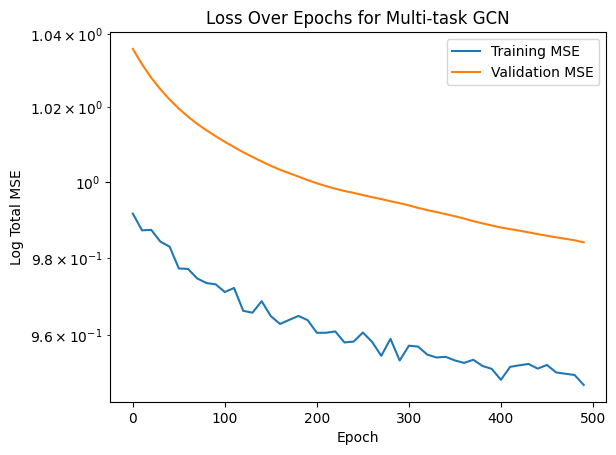

Epoch 000 | Train: 0.9950 | Val: 1.0119 * NEW BEST
Epoch 010 | Train: 0.9879 | Val: 1.0109 * NEW BEST
Epoch 020 | Train: 0.9896 | Val: 1.0103 * NEW BEST
Epoch 030 | Train: 0.9860 | Val: 1.0097 * NEW BEST
Epoch 040 | Train: 0.9843 | Val: 1.0093 * NEW BEST
Epoch 050 | Train: 0.9809 | Val: 1.0088 * NEW BEST
Epoch 060 | Train: 0.9759 | Val: 1.0084 * NEW BEST
Epoch 070 | Train: 0.9779 | Val: 1.0080 * NEW BEST
Epoch 080 | Train: 0.9772 | Val: 1.0076 * NEW BEST
Epoch 090 | Train: 0.9767 | Val: 1.0072 * NEW BEST
Epoch 100 | Train: 0.9733 | Val: 1.0066 * NEW BEST
Epoch 110 | Train: 0.9726 | Val: 1.0061 * NEW BEST
Epoch 120 | Train: 0.9688 | Val: 1.0055 * NEW BEST
Epoch 130 | Train: 0.9688 | Val: 1.0048 * NEW BEST
Epoch 140 | Train: 0.9753 | Val: 1.0042 * NEW BEST
Epoch 150 | Train: 0.9671 | Val: 1.0035 * NEW BEST
Epoch 160 | Train: 0.9658 | Val: 1.0031 * NEW BEST
Epoch 170 | Train: 0.9646 | Val: 1.0026 * NEW BEST
Epoch 180 | Train: 0.9667 | Val: 1.0021 * NEW BEST
Epoch 190 | Train: 0.9687 | Val

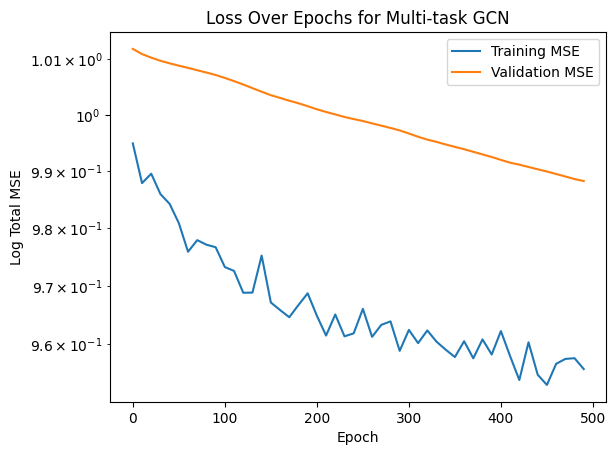

Epoch 000 | Train: 1.0078 | Val: 1.0156 * NEW BEST
Epoch 010 | Train: 1.0102 | Val: 1.0153 * NEW BEST
Epoch 020 | Train: 1.0076 | Val: 1.0151 * NEW BEST
Epoch 030 | Train: 1.0078 | Val: 1.0148 * NEW BEST
Epoch 040 | Train: 1.0068 | Val: 1.0146 * NEW BEST
Epoch 050 | Train: 1.0055 | Val: 1.0143 * NEW BEST
Epoch 060 | Train: 1.0059 | Val: 1.0141 * NEW BEST
Epoch 070 | Train: 1.0052 | Val: 1.0139 * NEW BEST
Epoch 080 | Train: 1.0048 | Val: 1.0136 * NEW BEST
Epoch 090 | Train: 1.0055 | Val: 1.0134 * NEW BEST
Epoch 100 | Train: 1.0077 | Val: 1.0132 * NEW BEST
Epoch 110 | Train: 1.0035 | Val: 1.0130 * NEW BEST
Epoch 120 | Train: 1.0049 | Val: 1.0127 * NEW BEST
Epoch 130 | Train: 1.0028 | Val: 1.0125 * NEW BEST
Epoch 140 | Train: 1.0038 | Val: 1.0123 * NEW BEST
Epoch 150 | Train: 1.0021 | Val: 1.0121 * NEW BEST
Epoch 160 | Train: 1.0027 | Val: 1.0119 * NEW BEST
Epoch 170 | Train: 1.0041 | Val: 1.0117 * NEW BEST
Epoch 180 | Train: 1.0025 | Val: 1.0115 * NEW BEST
Epoch 190 | Train: 1.0021 | Val

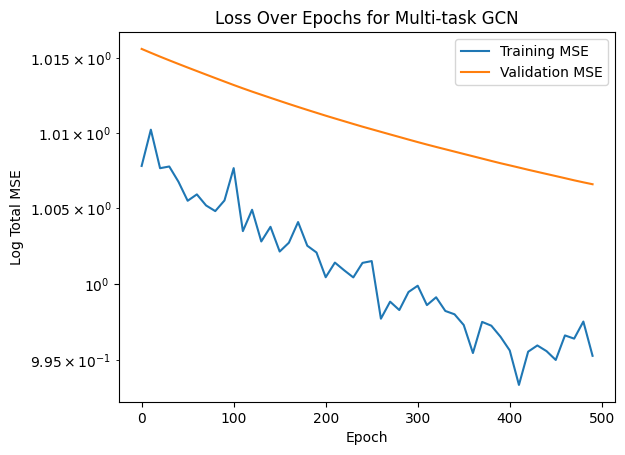

Epoch 000 | Train: 1.0267 | Val: 1.0654 * NEW BEST
Epoch 010 | Train: 1.0293 | Val: 1.0649 * NEW BEST
Epoch 020 | Train: 1.0282 | Val: 1.0644 * NEW BEST
Epoch 030 | Train: 1.0253 | Val: 1.0640 * NEW BEST
Epoch 040 | Train: 1.0273 | Val: 1.0635 * NEW BEST
Epoch 050 | Train: 1.0244 | Val: 1.0630 * NEW BEST
Epoch 060 | Train: 1.0252 | Val: 1.0626 * NEW BEST
Epoch 070 | Train: 1.0243 | Val: 1.0621 * NEW BEST
Epoch 080 | Train: 1.0229 | Val: 1.0617 * NEW BEST
Epoch 090 | Train: 1.0256 | Val: 1.0612 * NEW BEST
Epoch 100 | Train: 1.0194 | Val: 1.0608 * NEW BEST
Epoch 110 | Train: 1.0203 | Val: 1.0604 * NEW BEST
Epoch 120 | Train: 1.0225 | Val: 1.0599 * NEW BEST
Epoch 130 | Train: 1.0217 | Val: 1.0595 * NEW BEST
Epoch 140 | Train: 1.0185 | Val: 1.0591 * NEW BEST
Epoch 150 | Train: 1.0202 | Val: 1.0587 * NEW BEST
Epoch 160 | Train: 1.0206 | Val: 1.0583 * NEW BEST
Epoch 170 | Train: 1.0202 | Val: 1.0578 * NEW BEST
Epoch 180 | Train: 1.0189 | Val: 1.0574 * NEW BEST
Epoch 190 | Train: 1.0210 | Val

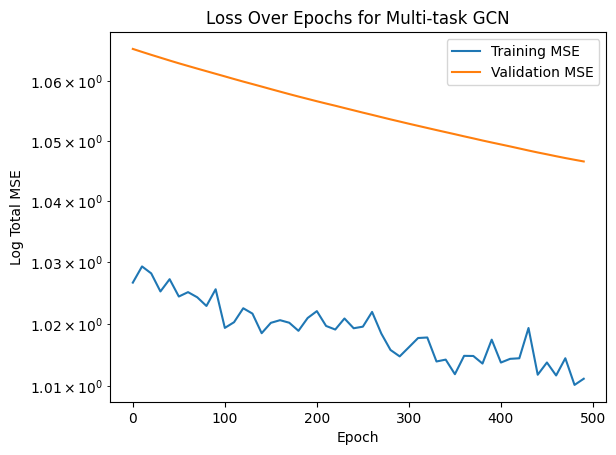

Epoch 000 | Train: 1.0334 | Val: 1.0742 * NEW BEST
Epoch 010 | Train: 1.0257 | Val: 1.0736 * NEW BEST
Epoch 020 | Train: 1.0258 | Val: 1.0730 * NEW BEST
Epoch 030 | Train: 1.0242 | Val: 1.0724 * NEW BEST
Epoch 040 | Train: 1.0197 | Val: 1.0718 * NEW BEST
Epoch 050 | Train: 1.0310 | Val: 1.0712 * NEW BEST
Epoch 060 | Train: 1.0264 | Val: 1.0707 * NEW BEST
Epoch 070 | Train: 1.0248 | Val: 1.0701 * NEW BEST
Epoch 080 | Train: 1.0195 | Val: 1.0695 * NEW BEST
Epoch 090 | Train: 1.0251 | Val: 1.0690 * NEW BEST
Epoch 100 | Train: 1.0277 | Val: 1.0684 * NEW BEST
Epoch 110 | Train: 1.0233 | Val: 1.0678 * NEW BEST
Epoch 120 | Train: 1.0236 | Val: 1.0673 * NEW BEST
Epoch 130 | Train: 1.0259 | Val: 1.0667 * NEW BEST
Epoch 140 | Train: 1.0208 | Val: 1.0662 * NEW BEST
Epoch 150 | Train: 1.0184 | Val: 1.0657 * NEW BEST
Epoch 160 | Train: 1.0205 | Val: 1.0651 * NEW BEST
Epoch 170 | Train: 1.0168 | Val: 1.0646 * NEW BEST
Epoch 180 | Train: 1.0234 | Val: 1.0641 * NEW BEST
Epoch 190 | Train: 1.0187 | Val

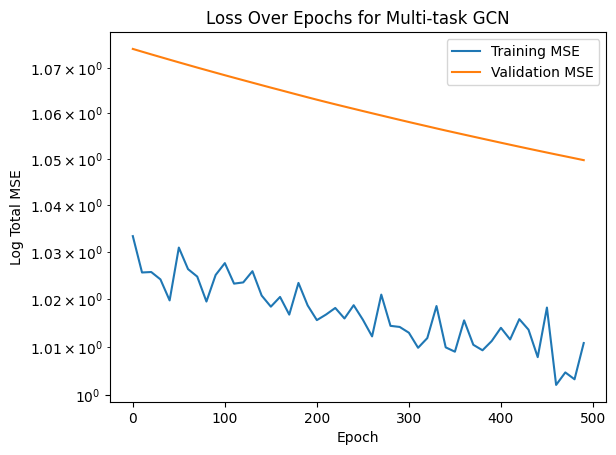

Epoch 000 | Train: 1.0040 | Val: 1.0329 * NEW BEST
Epoch 010 | Train: 0.9919 | Val: 1.0327 * NEW BEST
Epoch 020 | Train: 1.0008 | Val: 1.0324 * NEW BEST
Epoch 030 | Train: 0.9964 | Val: 1.0322 * NEW BEST
Epoch 040 | Train: 0.9970 | Val: 1.0320 * NEW BEST
Epoch 050 | Train: 1.0025 | Val: 1.0317 * NEW BEST
Epoch 060 | Train: 1.0014 | Val: 1.0315 * NEW BEST
Epoch 070 | Train: 0.9985 | Val: 1.0313 * NEW BEST
Epoch 080 | Train: 0.9913 | Val: 1.0310 * NEW BEST
Epoch 090 | Train: 0.9983 | Val: 1.0308 * NEW BEST
Epoch 100 | Train: 0.9984 | Val: 1.0306 * NEW BEST
Epoch 110 | Train: 0.9877 | Val: 1.0303 * NEW BEST
Epoch 120 | Train: 0.9989 | Val: 1.0301 * NEW BEST
Epoch 130 | Train: 0.9870 | Val: 1.0299 * NEW BEST
Epoch 140 | Train: 1.0027 | Val: 1.0297 * NEW BEST
Epoch 150 | Train: 1.0032 | Val: 1.0295 * NEW BEST
Epoch 160 | Train: 0.9910 | Val: 1.0293 * NEW BEST
Epoch 170 | Train: 0.9850 | Val: 1.0291 * NEW BEST
Epoch 180 | Train: 1.0067 | Val: 1.0289 * NEW BEST
Epoch 190 | Train: 0.9864 | Val

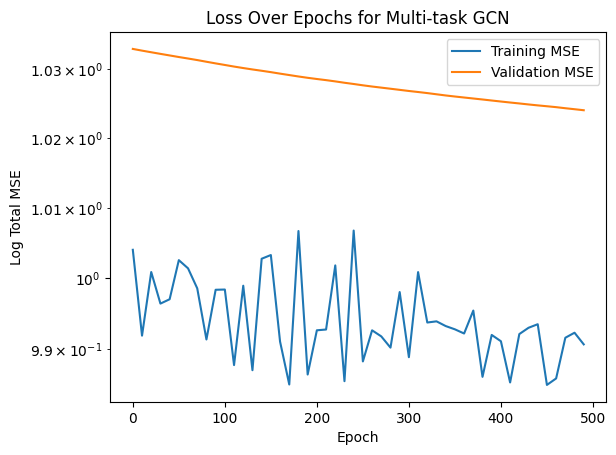

Epoch 000 | Train: 0.9987 | Val: 1.0127 * NEW BEST
Epoch 010 | Train: 0.9988 | Val: 1.0126 * NEW BEST
Epoch 020 | Train: 0.9985 | Val: 1.0125 * NEW BEST
Epoch 030 | Train: 0.9988 | Val: 1.0124 * NEW BEST
Epoch 040 | Train: 0.9991 | Val: 1.0123 * NEW BEST
Epoch 050 | Train: 0.9980 | Val: 1.0122 * NEW BEST
Epoch 060 | Train: 0.9963 | Val: 1.0121 * NEW BEST
Epoch 070 | Train: 0.9972 | Val: 1.0120 * NEW BEST
Epoch 080 | Train: 0.9962 | Val: 1.0119 * NEW BEST
Epoch 090 | Train: 0.9950 | Val: 1.0118 * NEW BEST
Epoch 100 | Train: 0.9947 | Val: 1.0117 * NEW BEST
Epoch 110 | Train: 0.9953 | Val: 1.0116 * NEW BEST
Epoch 120 | Train: 0.9963 | Val: 1.0115 * NEW BEST
Epoch 130 | Train: 0.9950 | Val: 1.0114 * NEW BEST
Epoch 140 | Train: 0.9926 | Val: 1.0113 * NEW BEST
Epoch 150 | Train: 0.9947 | Val: 1.0112 * NEW BEST
Epoch 160 | Train: 0.9931 | Val: 1.0111 * NEW BEST
Epoch 170 | Train: 0.9926 | Val: 1.0110 * NEW BEST
Epoch 180 | Train: 0.9916 | Val: 1.0110 * NEW BEST
Epoch 190 | Train: 0.9930 | Val

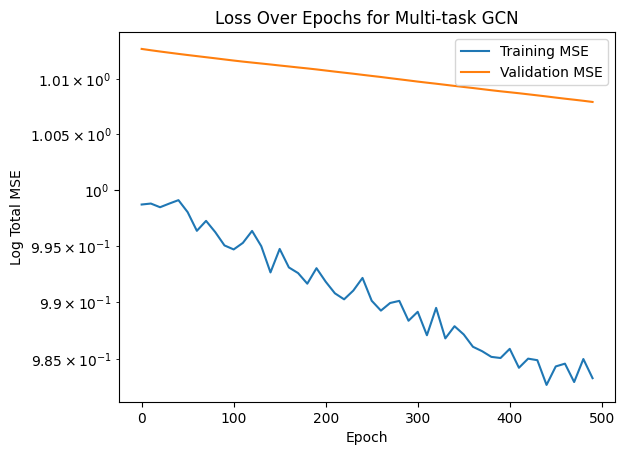

Epoch 000 | Train: 0.9973 | Val: 1.0231 * NEW BEST
Epoch 010 | Train: 0.9988 | Val: 1.0228 * NEW BEST
Epoch 020 | Train: 0.9988 | Val: 1.0226 * NEW BEST
Epoch 030 | Train: 0.9988 | Val: 1.0223 * NEW BEST
Epoch 040 | Train: 0.9995 | Val: 1.0221 * NEW BEST
Epoch 050 | Train: 0.9966 | Val: 1.0218 * NEW BEST
Epoch 060 | Train: 0.9955 | Val: 1.0216 * NEW BEST
Epoch 070 | Train: 0.9947 | Val: 1.0214 * NEW BEST
Epoch 080 | Train: 0.9934 | Val: 1.0212 * NEW BEST
Epoch 090 | Train: 0.9953 | Val: 1.0209 * NEW BEST
Epoch 100 | Train: 0.9950 | Val: 1.0207 * NEW BEST
Epoch 110 | Train: 0.9946 | Val: 1.0205 * NEW BEST
Epoch 120 | Train: 0.9939 | Val: 1.0203 * NEW BEST
Epoch 130 | Train: 0.9944 | Val: 1.0200 * NEW BEST
Epoch 140 | Train: 0.9924 | Val: 1.0198 * NEW BEST
Epoch 150 | Train: 0.9924 | Val: 1.0196 * NEW BEST
Epoch 160 | Train: 0.9921 | Val: 1.0194 * NEW BEST
Epoch 170 | Train: 0.9939 | Val: 1.0192 * NEW BEST
Epoch 180 | Train: 0.9898 | Val: 1.0190 * NEW BEST
Epoch 190 | Train: 0.9901 | Val

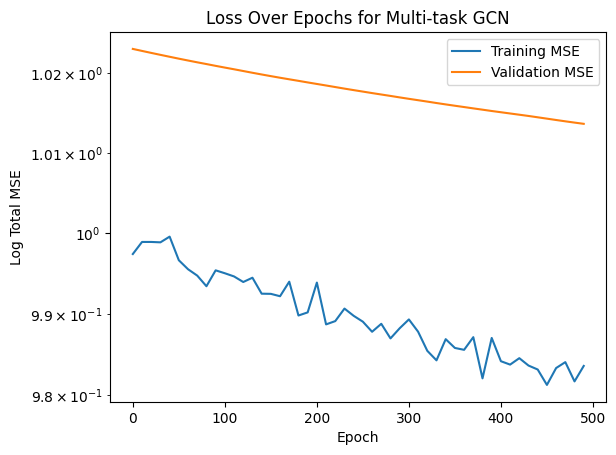

Epoch 000 | Train: 1.0031 | Val: 1.0369 * NEW BEST
Epoch 010 | Train: 0.9985 | Val: 1.0364 * NEW BEST
Epoch 020 | Train: 1.0012 | Val: 1.0359 * NEW BEST
Epoch 030 | Train: 1.0015 | Val: 1.0354 * NEW BEST
Epoch 040 | Train: 0.9977 | Val: 1.0349 * NEW BEST
Epoch 050 | Train: 0.9994 | Val: 1.0344 * NEW BEST
Epoch 060 | Train: 0.9992 | Val: 1.0339 * NEW BEST
Epoch 070 | Train: 0.9998 | Val: 1.0335 * NEW BEST
Epoch 080 | Train: 0.9928 | Val: 1.0330 * NEW BEST
Epoch 090 | Train: 1.0009 | Val: 1.0325 * NEW BEST
Epoch 100 | Train: 0.9967 | Val: 1.0321 * NEW BEST
Epoch 110 | Train: 0.9956 | Val: 1.0317 * NEW BEST
Epoch 120 | Train: 0.9985 | Val: 1.0312 * NEW BEST
Epoch 130 | Train: 0.9983 | Val: 1.0308 * NEW BEST
Epoch 140 | Train: 0.9962 | Val: 1.0304 * NEW BEST
Epoch 150 | Train: 0.9929 | Val: 1.0300 * NEW BEST
Epoch 160 | Train: 0.9939 | Val: 1.0296 * NEW BEST
Epoch 170 | Train: 0.9952 | Val: 1.0292 * NEW BEST
Epoch 180 | Train: 0.9954 | Val: 1.0288 * NEW BEST
Epoch 190 | Train: 0.9948 | Val

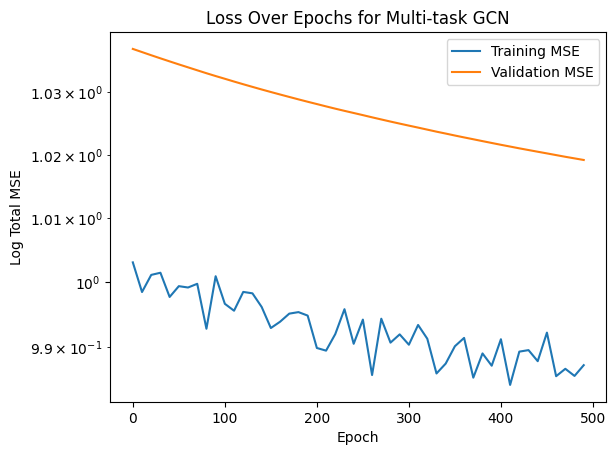

Epoch 000 | Train: 1.0105 | Val: 1.0124 * NEW BEST
Epoch 010 | Train: 1.0139 | Val: 1.0122 * NEW BEST
Epoch 020 | Train: 1.0206 | Val: 1.0120 * NEW BEST
Epoch 030 | Train: 1.0096 | Val: 1.0118 * NEW BEST
Epoch 040 | Train: 1.0142 | Val: 1.0116 * NEW BEST
Epoch 050 | Train: 1.0125 | Val: 1.0114 * NEW BEST
Epoch 060 | Train: 1.0165 | Val: 1.0112 * NEW BEST
Epoch 070 | Train: 1.0097 | Val: 1.0110 * NEW BEST
Epoch 080 | Train: 1.0071 | Val: 1.0108 * NEW BEST
Epoch 090 | Train: 1.0074 | Val: 1.0107 * NEW BEST
Epoch 100 | Train: 1.0062 | Val: 1.0105 * NEW BEST
Epoch 110 | Train: 1.0063 | Val: 1.0103 * NEW BEST
Epoch 120 | Train: 1.0036 | Val: 1.0102 * NEW BEST
Epoch 130 | Train: 1.0032 | Val: 1.0100 * NEW BEST
Epoch 140 | Train: 1.0051 | Val: 1.0098 * NEW BEST
Epoch 150 | Train: 1.0054 | Val: 1.0097 * NEW BEST
Epoch 160 | Train: 1.0117 | Val: 1.0095 * NEW BEST
Epoch 170 | Train: 1.0043 | Val: 1.0094 * NEW BEST
Epoch 180 | Train: 1.0090 | Val: 1.0092 * NEW BEST
Epoch 190 | Train: 1.0070 | Val

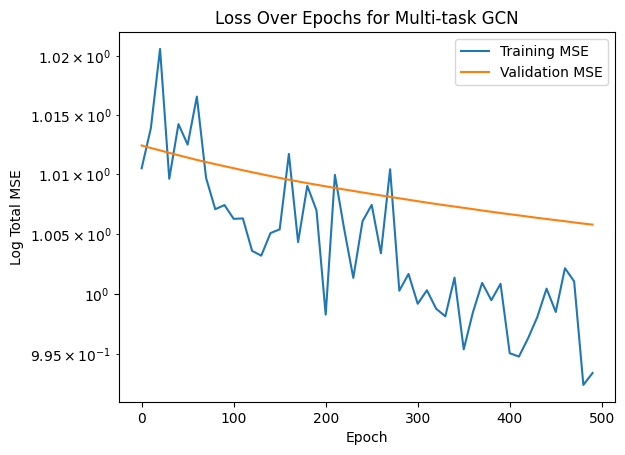

Epoch 000 | Train: 0.9806 | Val: 1.0052 * NEW BEST
Epoch 010 | Train: 0.9803 | Val: 1.0049 * NEW BEST
Epoch 020 | Train: 0.9783 | Val: 1.0047 * NEW BEST
Epoch 030 | Train: 0.9788 | Val: 1.0044 * NEW BEST
Epoch 040 | Train: 0.9774 | Val: 1.0042 * NEW BEST
Epoch 050 | Train: 0.9764 | Val: 1.0040 * NEW BEST
Epoch 060 | Train: 0.9773 | Val: 1.0037 * NEW BEST
Epoch 070 | Train: 0.9768 | Val: 1.0035 * NEW BEST
Epoch 080 | Train: 0.9768 | Val: 1.0032 * NEW BEST
Epoch 090 | Train: 0.9755 | Val: 1.0030 * NEW BEST
Epoch 100 | Train: 0.9750 | Val: 1.0028 * NEW BEST
Epoch 110 | Train: 0.9759 | Val: 1.0026 * NEW BEST
Epoch 120 | Train: 0.9760 | Val: 1.0024 * NEW BEST
Epoch 130 | Train: 0.9743 | Val: 1.0022 * NEW BEST
Epoch 140 | Train: 0.9743 | Val: 1.0019 * NEW BEST
Epoch 150 | Train: 0.9733 | Val: 1.0017 * NEW BEST
Epoch 160 | Train: 0.9732 | Val: 1.0015 * NEW BEST
Epoch 170 | Train: 0.9736 | Val: 1.0013 * NEW BEST
Epoch 180 | Train: 0.9732 | Val: 1.0011 * NEW BEST
Epoch 190 | Train: 0.9715 | Val

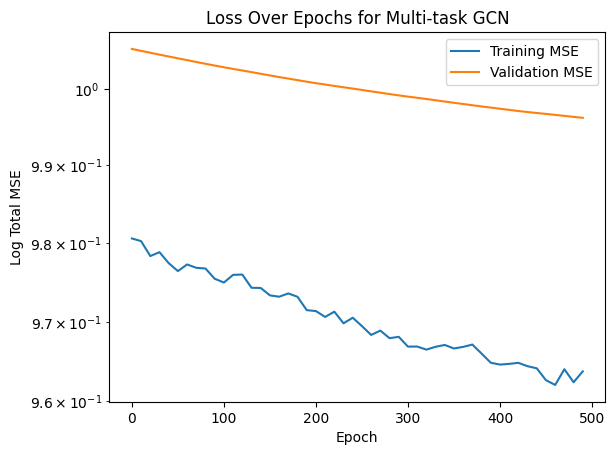

Epoch 000 | Train: 0.9939 | Val: 1.0090 * NEW BEST
Epoch 010 | Train: 0.9953 | Val: 1.0084 * NEW BEST
Epoch 020 | Train: 0.9910 | Val: 1.0079 * NEW BEST
Epoch 030 | Train: 0.9897 | Val: 1.0074 * NEW BEST
Epoch 040 | Train: 0.9906 | Val: 1.0068 * NEW BEST
Epoch 050 | Train: 0.9872 | Val: 1.0064 * NEW BEST
Epoch 060 | Train: 0.9873 | Val: 1.0059 * NEW BEST
Epoch 070 | Train: 0.9869 | Val: 1.0054 * NEW BEST
Epoch 080 | Train: 0.9869 | Val: 1.0050 * NEW BEST
Epoch 090 | Train: 0.9859 | Val: 1.0046 * NEW BEST
Epoch 100 | Train: 0.9863 | Val: 1.0042 * NEW BEST
Epoch 110 | Train: 0.9859 | Val: 1.0038 * NEW BEST
Epoch 120 | Train: 0.9839 | Val: 1.0034 * NEW BEST
Epoch 130 | Train: 0.9824 | Val: 1.0030 * NEW BEST
Epoch 140 | Train: 0.9840 | Val: 1.0026 * NEW BEST
Epoch 150 | Train: 0.9825 | Val: 1.0022 * NEW BEST
Epoch 160 | Train: 0.9801 | Val: 1.0019 * NEW BEST
Epoch 170 | Train: 0.9822 | Val: 1.0015 * NEW BEST
Epoch 180 | Train: 0.9799 | Val: 1.0012 * NEW BEST
Epoch 190 | Train: 0.9782 | Val

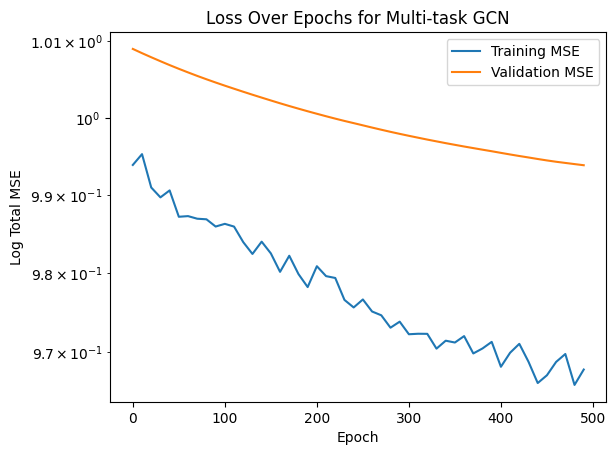

Epoch 000 | Train: 0.9944 | Val: 1.0193 * NEW BEST
Epoch 010 | Train: 0.9942 | Val: 1.0190 * NEW BEST
Epoch 020 | Train: 0.9937 | Val: 1.0186 * NEW BEST
Epoch 030 | Train: 0.9931 | Val: 1.0183 * NEW BEST
Epoch 040 | Train: 0.9929 | Val: 1.0180 * NEW BEST
Epoch 050 | Train: 0.9910 | Val: 1.0177 * NEW BEST
Epoch 060 | Train: 0.9934 | Val: 1.0174 * NEW BEST
Epoch 070 | Train: 0.9906 | Val: 1.0171 * NEW BEST
Epoch 080 | Train: 0.9919 | Val: 1.0167 * NEW BEST
Epoch 090 | Train: 0.9899 | Val: 1.0165 * NEW BEST
Epoch 100 | Train: 0.9891 | Val: 1.0162 * NEW BEST
Epoch 110 | Train: 0.9895 | Val: 1.0159 * NEW BEST
Epoch 120 | Train: 0.9838 | Val: 1.0156 * NEW BEST
Epoch 130 | Train: 0.9901 | Val: 1.0153 * NEW BEST
Epoch 140 | Train: 0.9901 | Val: 1.0151 * NEW BEST
Epoch 150 | Train: 0.9863 | Val: 1.0148 * NEW BEST
Epoch 160 | Train: 0.9870 | Val: 1.0145 * NEW BEST
Epoch 170 | Train: 0.9851 | Val: 1.0143 * NEW BEST
Epoch 180 | Train: 0.9859 | Val: 1.0140 * NEW BEST
Epoch 190 | Train: 0.9871 | Val

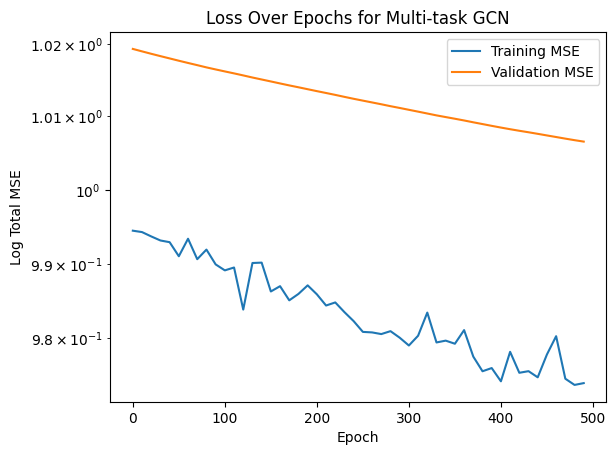

Epoch 000 | Train: 0.9874 | Val: 1.0121 * NEW BEST
Epoch 010 | Train: 0.9866 | Val: 1.0116 * NEW BEST
Epoch 020 | Train: 0.9855 | Val: 1.0112 * NEW BEST
Epoch 030 | Train: 0.9863 | Val: 1.0107 * NEW BEST
Epoch 040 | Train: 0.9858 | Val: 1.0103 * NEW BEST
Epoch 050 | Train: 0.9786 | Val: 1.0098 * NEW BEST
Epoch 060 | Train: 0.9819 | Val: 1.0094 * NEW BEST
Epoch 070 | Train: 0.9846 | Val: 1.0090 * NEW BEST
Epoch 080 | Train: 0.9812 | Val: 1.0085 * NEW BEST
Epoch 090 | Train: 0.9860 | Val: 1.0081 * NEW BEST
Epoch 100 | Train: 0.9814 | Val: 1.0077 * NEW BEST
Epoch 110 | Train: 0.9810 | Val: 1.0073 * NEW BEST
Epoch 120 | Train: 0.9804 | Val: 1.0069 * NEW BEST
Epoch 130 | Train: 0.9820 | Val: 1.0066 * NEW BEST
Epoch 140 | Train: 0.9813 | Val: 1.0062 * NEW BEST
Epoch 150 | Train: 0.9826 | Val: 1.0059 * NEW BEST
Epoch 160 | Train: 0.9785 | Val: 1.0055 * NEW BEST
Epoch 170 | Train: 0.9806 | Val: 1.0052 * NEW BEST
Epoch 180 | Train: 0.9797 | Val: 1.0048 * NEW BEST
Epoch 190 | Train: 0.9797 | Val

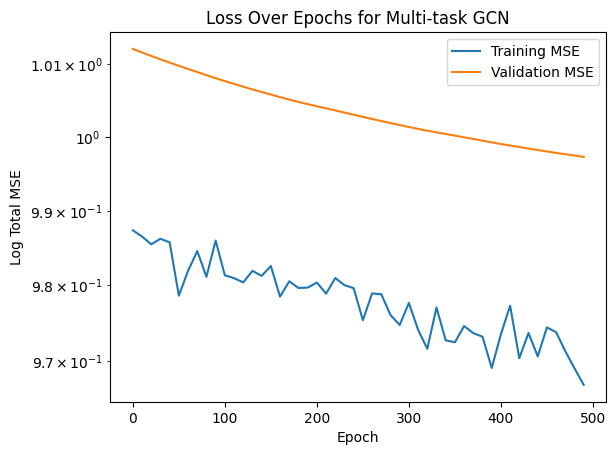

Best params: {'lr': 0.001, 'n_neurons': 64, 'dr': 0.5}
Best val loss: 0.9227765202522278


{'lr': 0.001, 'n_neurons': 64, 'dr': 0.5}

In [23]:
# hyperparameter tuning
My_Fit.hp_tuning(graph_data, X.shape[1])